In [1]:
# ----------- Importazione delle librerie standard e di terze parti -----------
# Moduli per la manipolazione dei dati e per operazioni matematiche
import pandas as pd
import numpy as np
import math
import re
import json
from collections import Counter
from operator import itemgetter
import string
# Moduli per le operazioni con le date
import datetime
from datetime import datetime, timedelta
import time
# Moduli per la gestione dei file e delle directory
import os
# Moduli per la visualizzazione dei dati
import matplotlib.pyplot as plt
import seaborn as sns
# Moduli per la gestione delle richieste HTTP e per la manipolazione del HTML
import requests
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from lxml import html
# Moduli per la gestione delle interfacce utente
import tkinter as tk
from tkinter import messagebox
# Moduli per l'apprendimento automatico e l'analisi del testo
import nltk
from nltk.corpus import stopwords

from nltk.stem import WordNetLemmatizer

from nltk.tokenize import word_tokenize
# Scarica i pacchetti necessari di nltk se non sono già presenti
nltk.download('averaged_perceptron_tagger')
nltk.download('omw')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
# Moduli specifici per l'analisi e la manipolazione del testo in italiano
import spacy

# Modulo per l'interazione con l'API di OpenAI
import openai
# Modulo per l'interazione con Google Search Console
# pip install git+https://github.com/joshcarty/google-searchconsole
import searchconsole
# Modulo per la visualizzazione della barra di avanzamento
from tqdm import tqdm

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package omw is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Utente\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from dotenv import load_dotenv
import os
load_dotenv()  # Carica le variabili d'ambiente dal file .env
openai.api_key = os.getenv("openai.api_key")

In [3]:
# OPZIONI

## LINGUA ################################################################
language = 'it' # it/en
## LOADING NLP ################################################################
if language == 'it':
    # ITALIANO
    # update
    # python -m spacy download it_core_news_lg
    #nlp = spacy.load("it_core_news_lg", disable=["tagger", "parser", "entityrecognizer"])
    from nltk.stem.snowball import SnowballStemmer
    nlp = spacy.load("it_core_news_lg", disable=["parser", "ner"])
    stemmer = SnowballStemmer("italian")
    stopwords = stopwords.words('italian')
    language = 'italiano'
elif language == 'en':
    # INGLESE
    # Download the English model
    # python -m spacy download en_core_web_lg
    #nlp = spacy.load("en_core_web_lg", disable=["tagger", "parser", "entity_recognizer"])
    from nltk.stem import PorterStemmer
    nlp = spacy.load("en_core_web_lg", disable=["parser", "ner"])
    stemmer = PorterStemmer()
    stopwords = stopwords.words('english')
    language = 'inglese'
print(f'{language} loaded')

#################################################################
## DATI GSC - number of days to split into segments min 3 max 365
giorni = 18 # valore da 1 a 480
# filtri URL per chiamate GSC
contains_gsc = ""
# filtro COUNTRY, un solo valore - sigle country https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3
countryCall="" # ITA, USA, GBR, DEU, FRA, ...
## BRAND ###############################################################
query_brand = "evemilano|sacheli"
#################################################################
## HTTP CRAWLER - massime richieste crawler, min 1
counter_max = 1
# pausa tra una chiamata http e l'altra del title crawler
attesa=1
# Opzioni per la scelta dell'User-Agent per la scansione
user_agent_option = 'fixed'  # Opzioni: 'random', 'chrome', 'fixed'
# filtri URL da scansionare | separatore
include=""
exclude=""
## PREVISIONI ################################################
previsioni = 'no' # si/no
## FORMATTAZIONE ###############################################################
formattazione = 'no' # si/no
## FILTRI ###############################################################
min_imp = 100 # valore libero da 1 a infinito
max_pos = 100 # 1-100

italiano loaded


In [4]:
# Get the absolute path of the credentials file
creds_path = os.path.abspath("client_secret_.json")
# Load the client configuration from the file
with open(creds_path, 'r') as f:
    client_config = json.load(f)
# Authenticate with the Search Console API
#account = searchconsole.authenticate(client_config=client_config, serialize='credentials.json', flow='console')
account = searchconsole.authenticate(client_config=client_config, serialize='credentials.json', flow='web')

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=615773305903-ieefueojceq5624v7e9otk5clcneulpm.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8080%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fwebmasters.readonly&state=Vrs92AR8LliE2BYt6Tjzw72WQ44Zgm&access_type=offline


In [5]:
# Crea una finestra di dialogo per mostrare le proprietà filtrate

import tkinter as tk
from tkinter import messagebox

# Funzione per mostrare le proprietà filtrate
def show_properties(properties):
    def select_property():
        nonlocal selected
        try:
            selected = int(lb.curselection()[0])
            root.destroy()
        except:
            messagebox.showerror("Errore", "Devi selezionare una proprietà.")

    root = tk.Tk()
    root.title("Proprietà filtrate")
    root.geometry("640x480")
    lb = tk.Listbox(root)
    for prop in properties:
        lb.insert(tk.END, prop.url)
    lb.pack(fill=tk.BOTH, expand=True)
    select_button = tk.Button(root, text="Seleziona", command=select_property)
    select_button.pack(side=tk.BOTTOM, pady=10)
    selected = None
    root.mainloop()
    return selected

while True:
    # Chiede all'utente di inserire una parola chiave
    keyword = input("Inserisci la parola chiave per il filtro (oppure digita 'exit' per uscire): ")
    if keyword.lower() == 'exit':
        print("Script interrotto dall'utente.")
        break

    # Filtra le proprietà in base alla parola chiave
    filtered_properties = [prop for prop in account.webproperties if keyword in prop.url]
    
    # Gestisce i casi di nessuna proprietà trovata
    if len(filtered_properties) == 0:
        print("Nessuna proprietà trovata. Riprova.")
        continue

    # Mostra la finestra con le proprietà filtrate
    selected_index = show_properties(filtered_properties)
    if selected_index is None:
        print("Nessuna proprietà selezionata.")
    else:
        webproperty = filtered_properties[selected_index]
        print(f"Hai selezionato la proprietà {webproperty.url}")
        break


Hai selezionato la proprietà https://www.evemilano.com/


In [6]:
# se profilo GSC dominio, trasforma in URL
if webproperty.url.startswith("sc-domain:"):
    url = "https://" + webproperty.url[len("sc-domain:"):]
    # prova a connetterti al sito
    try:
        response = requests.get(url)
        if response.status_code == 200:
            print(f"Esiste. L'URL {url} ha restituito uno status code {response.status_code}")
        else:
            print(f"Non raggiungibile. L'URL {url} ha restituito uno status code {response.status_code}")
    except requests.exceptions.ConnectionError as e:
        print(f"Errore di connessione: {e}")
else:
    url = webproperty.url
    # prova a connetterti al sito
    try:
        response = requests.get(webproperty.url)
        if response.status_code == 200:
            print(f"Esiste. L'URL {webproperty.url} ha restituito uno status code {response.status_code}")
        else:
            print(f"Non raggiungibile. L'URL {webproperty.url} ha restituito uno status code {response.status_code}")
    except requests.exceptions.ConnectionError as e:
        print(f"Errore di connessione: {e}")

Esiste. L'URL https://www.evemilano.com/ ha restituito uno status code 200


In [7]:
##########################################
# opzione UX selezione sito web da lista #
##########################################
# usare pagina di selezione sito web già presente in altri tool sul server

# webproperty=account[str(property_name)]
# https://github.com/joshcarty/google-searchconsole

def extract_gsc_data(webproperty, start, stop, countryCall, contains_gsc, *args):
 if webproperty is not None:
   print(f'Extracting data for {webproperty}')
   gsc_data = webproperty.query.range(start, stop).dimension(*args).filter('country',countryCall,'contains').filter('page',contains_gsc,'contains').get()
   return gsc_data
 else:
   print('Webproperty not found, please select the correct one')
   return None

webproperty

<searchconsole.account.WebProperty(url='https://www.evemilano.com/')>

In [8]:
# crea pattern filename
# Ripulisci il nome della proprietà
property_name = webproperty.url.replace('https://', '').replace('http://', '').replace('www.', '').replace('/', '')
# Ottieni la data e l'ora corrente
now = datetime.now()
# Formatta la data e l'ora in una stringa
now_str = now.strftime("%Y%m%d_%H%M")
# crea filename pattern
file_name= f"GSC_EXT_{property_name}_{giorni}days_{counter_max}crawls_{now_str}"
file_name = file_name.replace(":", "-")

print(file_name)

# Specifica la cartella di output
output_dir = "output"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
# Crea il nome del file
filename = f"{file_name}.xlsx"
# crea cartella della property
new_output_dir = f"{output_dir}/{property_name}"
# Replace ":" with "-" in filename
new_output_dir=new_output_dir.replace(":", "-")
filename=filename.replace(":", "-")
# Crea la cartella se non esiste
os.makedirs(new_output_dir, exist_ok=True)
print(new_output_dir)
print(filename)

GSC_EXT_evemilano.com_18days_1crawls_20231129_2050
output/evemilano.com
GSC_EXT_evemilano.com_18days_1crawls_20231129_2050.xlsx


In [9]:
# Funzione per generare l'intervallo di date
def get_date_range(num_days_back):
    today = datetime.now()
    start_date = today - timedelta(days=num_days_back+1)
    end_date = today - timedelta(days=1)  # la data finale è ieri
    return start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

# Imposta il periodo di tempo
start_date, end_date = get_date_range(giorni)

# Converti le date in formato datetime se sono stringhe
if type(start_date) == str:
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
if type(end_date) == str:
    end_date = datetime.strptime(end_date, '%Y-%m-%d')

# Crea segmenti di un giorno
date_segments = [(start_date + timedelta(days=i), start_date + timedelta(days=i + 1) - timedelta(seconds=1))
                 for i in range((end_date - start_date).days)]

total_segments = len(date_segments)  # Calcola il numero totale di segmenti

# Lista per memorizzare i dati di ogni segmento
segment_data = []
max_attempts = 3  # Numero massimo di tentativi per chiamata

# Ciclo su ogni segmento di date
for index, (start, end) in enumerate(date_segments):
#for start, end in date_segments:
    completed = False
    attempts = 0
    no_data_found = False

    while not completed and attempts < max_attempts:
        try:
            #print(f'Requests from {start} to {end}')
            print(f'Requests from {start} to {end} ({index + 1}/{total_segments})')
            #ex = extract_gsc_data(webproperty, start, end, countryCall,'query', 'page', 'country','device')
            ex = extract_gsc_data(webproperty, start, end, countryCall,contains_gsc,'query', 'page')
        except Exception as e:
            print(f"Error: {e}")
            attempts += 1
            print(f"Retrying, attempt {attempts}/{max_attempts}...")
        else:
            if ex:
                segment_data.append(ex.to_dataframe())
                completed = True
            else:
                no_data_found = True
                break  # Interrompi il ciclo while se non vengono trovati dati
    if no_data_found:
        print(f"No data found for period {start} to {end}.")

# Concatenazione dei dati
final_data = pd.concat(segment_data, ignore_index=True)    
print(f'Rows: {final_data.shape[0]}')
final_data.head(5)

Requests from 2023-11-10 00:00:00 to 2023-11-10 23:59:59 (1/18)
Extracting data for <searchconsole.account.WebProperty(url='https://www.evemilano.com/')>


Requests from 2023-11-11 00:00:00 to 2023-11-11 23:59:59 (2/18)
Extracting data for <searchconsole.account.WebProperty(url='https://www.evemilano.com/')>
Requests from 2023-11-12 00:00:00 to 2023-11-12 23:59:59 (3/18)
Extracting data for <searchconsole.account.WebProperty(url='https://www.evemilano.com/')>
Requests from 2023-11-13 00:00:00 to 2023-11-13 23:59:59 (4/18)
Extracting data for <searchconsole.account.WebProperty(url='https://www.evemilano.com/')>
Requests from 2023-11-14 00:00:00 to 2023-11-14 23:59:59 (5/18)
Extracting data for <searchconsole.account.WebProperty(url='https://www.evemilano.com/')>
Requests from 2023-11-15 00:00:00 to 2023-11-15 23:59:59 (6/18)
Extracting data for <searchconsole.account.WebProperty(url='https://www.evemilano.com/')>
Requests from 2023-11-16 00:00:00 to 2023-11-16 23:59:59 (7/18)
Extracting data for <searchconsole.account.WebProperty(url='https://www.evemilano.com/')>
Requests from 2023-11-17 00:00:00 to 2023-11-17 23:59:59 (8/18)
Extracting d

,query,page,clicks,impressions,ctr,position
0,cdata xml,https://www.evemilano.com/cdata-xml/,2,11,0.181818,42.818182
1,come vedere la sitemap di un sito,https://www.evemilano.com/3-modi-per-trovare-l...,2,3,0.666667,1.000000
2,regex caratteri speciali,https://www.evemilano.com/come-funzionano-le-e...,2,2,1.000000,2.000000
3,xml cdata,https://www.evemilano.com/cdata-xml/,2,10,0.200000,39.700000
4,![cdata,https://www.evemilano.com/cdata-xml/,1,3,0.333333,5.666667


In [10]:
# Stampa la somma totale dei clicks e delle impressions
total_clicks = final_data['clicks'].sum()
total_impressions = final_data['impressions'].sum()
print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

Somma totale dei clicks: 1221
Somma totale delle impressions: 200821


In [11]:
# pulizia db raw 
# final_data contiene tutte le chiamate alle API
final_data1=final_data.copy()
######################################

# funzione di verifica idoneità del df e pulizia righe
def drop_rows_with_hash_and_empty_query(df):
    # Controlla se le COLONNE necessarie sono presenti nel DataFrame
    if 'page' not in df.columns or 'query' not in df.columns:
        print("Il DataFrame non ha le colonne necessarie ('page' o 'query'). Operazione interrotta.")
        return df
    # Rimuovi righe con '#' nel campo 'page'
    df = df[~df['page'].str.contains("#")]
    # Rimuovi righe con valori NaN, Null o vuoti nel campo 'query'
    df = df[df['query'].notnull() & (df['query'].str.strip() != '')]
    return df

# Controlla se il DataFrame esiste e ha almeno una riga
if 'final_data1' in locals() and not final_data1.empty:
    final_data1 = drop_rows_with_hash_and_empty_query(final_data1) # pulisci il dataframe
    # print e show
    print(f'{final_data1.shape[0]} righe')
    final_data1.head(1)
else:
    print("Il DataFrame non esiste o è vuoto. Operazione interrotta.")
    raise SystemExit


# Stampa la somma totale dei clicks e delle impressions
total_clicks = final_data1['clicks'].sum()
total_impressions = final_data1['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)
# formatta position in numero intero
final_data1['position'] = final_data1['position'].astype(int)
final_data1.head(5)

71858 righe
Somma totale dei clicks: 1219
Somma totale delle impressions: 178202


,query,page,clicks,impressions,ctr,position
0,cdata xml,https://www.evemilano.com/cdata-xml/,2,11,0.181818,42
1,come vedere la sitemap di un sito,https://www.evemilano.com/3-modi-per-trovare-l...,2,3,0.666667,1
2,regex caratteri speciali,https://www.evemilano.com/come-funzionano-le-e...,2,2,1.000000,2
3,xml cdata,https://www.evemilano.com/cdata-xml/,2,10,0.200000,39
4,![cdata,https://www.evemilano.com/cdata-xml/,1,3,0.333333,5


In [12]:
# Funzione per calcolare la media ponderata
def weighted_mean(values, weights):
    return np.sum(values * weights) / np.sum(weights)

In [13]:
# funzione formatta ctr
def format_ctr(value):
    if isinstance(value, float):
        return value / 100  # Converti il valore percentuale in float
    return value

In [14]:
# tabella pivot query uniche da API
print("Copiando i dati per la lavorazione...")
final_data2=final_data1.copy()

# Crea una tabella pivot con multi-livello di indici
print("Creando la tabella pivot...")
# Creazione della tabella pivot
export_api_pvt = final_data2.pivot_table(
    index=['query', 'page'], 
    values=['clicks', 'impressions', 'position'], 
    aggfunc={
        'clicks': 'sum', 
        'impressions': 'sum',
        'position': lambda x: weighted_mean(x, final_data2.loc[x.index, 'impressions'])
    }
)

# Calcolo del CTR direttamente sul pivot table
print("Calcolando il CTR...")
export_api_pvt['ctr'] = (export_api_pvt['clicks'] / export_api_pvt['impressions']) * 100

# Ordina la tabella pivot in base alle impressions
print("Ordinando la tabella pivot per impressions...")
export_api_pvt.sort_values(by='impressions', axis=0, ascending=False, inplace=True)

# rinomina e formatta position
print("Formattando e rinominando la colonna 'position'...")
export_api_pvt['position'] = export_api_pvt['position'].astype(int)
export_api_pvt = export_api_pvt.rename(columns={'position': 'weighted avg position'})


# Apply the formatting to the CTR column
print("Applicando la formattazione al CTR...")
export_api_pvt['ctr'] = export_api_pvt['ctr'].apply(format_ctr)

# ordina le colonne
print("Ordinando le colonne...")
export_api_pvt = export_api_pvt.reindex(columns=['clicks', 'impressions', 'ctr', 'weighted avg position'])

# Stampa la somma totale dei clicks e delle impressions
print("Calcolando la somma totale di clicks e impressions...")
total_clicks = export_api_pvt['clicks'].sum()
total_impressions = export_api_pvt['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

# Mostra la tabella pivot ordinata
print("Rows: " + str(export_api_pvt.shape[0]))
export_api_pvt.head(10)


# test con media calcolata fuori dalla pivot
# da testare su larghi dataset
if False:

    # tabella pivot query uniche da API
    # test speed senza vecchia funzione LAMBDA

    print("Copiando i dati per la lavorazione...")
    final_data2=final_data1.copy()

    # Calcola la posizione ponderata (weighted position) per ogni riga in final_data2
    final_data2['weighted_position'] = final_data2['position'] * final_data2['impressions']

    # Modifica la tabella pivot per usare il nuovo calcolo
    export_api_pvt = final_data2.pivot_table(
        index=['query', 'page'], 
        values=['clicks', 'impressions', 'weighted_position'], 
        aggfunc={
            'clicks': 'sum', 
            'impressions': 'sum',
            'weighted_position': 'sum'
        }
    )

    # Calcola la posizione finale ponderata
    export_api_pvt['position'] = export_api_pvt['weighted_position'] / export_api_pvt['impressions']
    export_api_pvt.drop(columns=['weighted_position'], inplace=True)

    # Calcolo del CTR direttamente sul pivot table
    print("Calcolando il CTR...")
    export_api_pvt['ctr'] = (export_api_pvt['clicks'] / export_api_pvt['impressions']) * 100

    # Ordina la tabella pivot in base alle impressions
    print("Ordinando la tabella pivot per impressions...")
    export_api_pvt.sort_values(by='impressions', axis=0, ascending=False, inplace=True)

    # rinomina e formatta position
    print("Formattando e rinominando la colonna 'position'...")
    export_api_pvt = export_api_pvt.rename(columns={'position': 'weighted avg position'})
    export_api_pvt['weighted avg position'] = export_api_pvt['weighted avg position'].astype(int)

    # Apply the formatting to the CTR column 
    print("Applicando la formattazione al CTR...")
    export_api_pvt['ctr'] = export_api_pvt['ctr'].apply(format_ctr)

    # ordina le colonne
    print("Ordinando le colonne...")
    export_api_pvt = export_api_pvt.reindex(columns=['clicks', 'impressions', 'ctr', 'weighted avg position'])

    # Stampa la somma totale dei clicks e delle impressions
    print("Calcolando la somma totale di clicks e impressions...")
    total_clicks = export_api_pvt['clicks'].sum()
    total_impressions = export_api_pvt['impressions'].sum()

    print("Somma totale dei clicks:", total_clicks)
    print("Somma totale delle impressions:", total_impressions)

    # Mostra la tabella pivot ordinata
    print("Rows: " + str(export_api_pvt.shape[0]))
    export_api_pvt.head(5)

Copiando i dati per la lavorazione...
Creando la tabella pivot...
Calcolando il CTR...
Ordinando la tabella pivot per impressions...
Formattando e rinominando la colonna 'position'...
Applicando la formattazione al CTR...
Ordinando le colonne...
Calcolando la somma totale di clicks e impressions...
Somma totale dei clicks: 1219
Somma totale delle impressions: 178202
Rows: 16539


In [15]:
# crea foglio raw
raw_df = export_api_pvt.copy()
raw_df = raw_df.reset_index()
print("Rows: " + str(raw_df.shape[0]))
raw_df.head(3)

Rows: 16539


,query,page,clicks,impressions,ctr,weighted avg position
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,0.000000,8
1,web archive,https://www.evemilano.com/web-archive/,16,3735,0.004284,4
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,0.003227,4


In [16]:
# PULIZIA E embedding delle query
###################################################################################
print("Preparazione dei dati")
print("Conversione colonna query in stringa")
raw_df['query'] = raw_df['query'].fillna('').apply(str)
print("Creazione colonna conta caratteri")
raw_df['Char'] = raw_df['query'].apply(len)  

print("Rimozione stopword e applica stemming in un unico passaggio")
raw_df['Stemming'] = raw_df['query'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in x.split() if word.lower() not in stopwords]))

print("Conteggio stemmi e ordinamento per frequenza")
stem_counts = Counter(' '.join(raw_df['Stemming']).split())
sorted_stems = sorted(stem_counts.items(), key=itemgetter(1), reverse=True)

print("Mappatura degli stemmi alle loro posizioni nella lista ordinata")
stem_position_dict = {stem: i for i, (stem, _) in enumerate(sorted_stems)}

print("Creazione della nuova colonna ordinando gli stemmi per frequenza")
raw_df['Stems Ordered by frequency'] = raw_df['Stemming'].apply(
    lambda x: ' '.join(sorted(x.split(), key=stem_position_dict.get)))

print("Creazione della nuova colonna Stemma più frequente")
raw_df['Strongest word stem'] = raw_df['Stems Ordered by frequency'].str.split().str[0]

print("Eliminazione colonna Stemming")
#raw_df = raw_df.drop([ 'Stemming'], axis=1)

# Stampa la somma totale dei clicks e delle impressions
total_clicks = raw_df['clicks'].sum()
total_impressions = raw_df['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

raw_df.head(6)

Preparazione dei dati
Conversione colonna query in stringa
Creazione colonna conta caratteri
Rimozione stopword e applica stemming in un unico passaggio
Conteggio stemmi e ordinamento per frequenza
Mappatura degli stemmi alle loro posizioni nella lista ordinata
Creazione della nuova colonna ordinando gli stemmi per frequenza
Creazione della nuova colonna Stemma più frequente
Eliminazione colonna Stemming
Somma totale dei clicks: 1219
Somma totale delle impressions: 178202


,query,page,clicks,impressions,ctr,weighted avg position,Char,Stemming,Stems Ordered by frequency,Strongest word stem
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,0.000000,8,5,proxy,proxy,proxy
1,web archive,https://www.evemilano.com/web-archive/,16,3735,0.004284,4,11,web archiv,web archiv,web
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,0.003227,4,10,webarc,webarc,webarc
3,gdpr significato,https://www.evemilano.com/gdpr/,0,2420,0.000000,8,16,gdpr signific,signific gdpr,signific
4,l'indirizzo completo di un sito,https://www.evemilano.com/come-trovare-indiriz...,0,1681,0.000000,9,31,l'indirizz complet sit,sit l'indirizz complet,sit
5,agenzia seo,https://www.evemilano.com/servizi-seo/agenzia/,0,1624,0.000000,91,11,agenz seo,seo agenz,seo


In [17]:
# PULIZIA E embedding delle query con spaCy 
from collections import Counter
from operator import itemgetter

# Caricare il modello italiano di spaCy

print("Preparazione dei dati")
print("Conversione colonna query in stringa")
raw_df['query'] = raw_df['query'].fillna('').apply(str)
print("Creazione colonna conta caratteri")
raw_df['Char'] = raw_df['query'].apply(len)  

print("Rimozione stopword e applicazione della lemmatizzazione in un unico passaggio")
def process_text(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])

raw_df['Lemmatized'] = raw_df['query'].apply(process_text)


print("Conteggio lemmi e ordinamento per frequenza")
lemma_counts = Counter(' '.join(raw_df['Lemmatized']).split())
sorted_lemmas = sorted(lemma_counts.items(), key=itemgetter(1), reverse=True)

print("Mappatura dei lemmi alle loro posizioni nella lista ordinata")
lemma_position_dict = {lemma: i for i, (lemma, _) in enumerate(sorted_lemmas)}

print("Creazione della nuova colonna ordinando i lemmi per frequenza")
raw_df['Lemmas Ordered by frequency'] = raw_df['Lemmatized'].apply(
    lambda x: ' '.join(sorted(x.split(), key=lemma_position_dict.get)))

print("Creazione della nuova colonna Lemma più frequente")
raw_df['Strongest lemma'] = raw_df['Lemmas Ordered by frequency'].str.split().str[0]

print("Eliminazione colonna Lemmatized")
#raw_df = raw_df.drop(['Lemmatized'], axis=1)

# Stampa la somma totale dei clicks e delle impressions
total_clicks = raw_df['clicks'].sum()
total_impressions = raw_df['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

raw_df.head(6)


Preparazione dei dati
Conversione colonna query in stringa
Creazione colonna conta caratteri
Rimozione stopword e applicazione della lemmatizzazione in un unico passaggio
Conteggio lemmi e ordinamento per frequenza
Mappatura dei lemmi alle loro posizioni nella lista ordinata
Creazione della nuova colonna ordinando i lemmi per frequenza
Creazione della nuova colonna Lemma più frequente
Eliminazione colonna Lemmatized
Somma totale dei clicks: 1219
Somma totale delle impressions: 178202


,query,page,clicks,impressions,ctr,weighted avg position,Char,Stemming,Stems Ordered by frequency,Strongest word stem,Lemmatized,Lemmas Ordered by frequency,Strongest lemma
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,0.000000,8,5,proxy,proxy,proxy,proxy,proxy,proxy
1,web archive,https://www.evemilano.com/web-archive/,16,3735,0.004284,4,11,web archiv,web archiv,web,web archive,web archive,web
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,0.003227,4,10,webarc,webarc,webarc,Webarchive,Webarchive,Webarchive
3,gdpr significato,https://www.evemilano.com/gdpr/,0,2420,0.000000,8,16,gdpr signific,signific gdpr,signific,gdpr significato,significato gdpr,significato
4,l'indirizzo completo di un sito,https://www.evemilano.com/come-trovare-indiriz...,0,1681,0.000000,9,31,l'indirizz complet sit,sit l'indirizz complet,sit,indirizzo completo sito,sito indirizzo completo,sito
5,agenzia seo,https://www.evemilano.com/servizi-seo/agenzia/,0,1624,0.000000,91,11,agenz seo,seo agenz,seo,agenzia seo,seo agenzia,seo


In [18]:
# classificazione spacy versione ottimizzata con pipe
print('Elaborazione dei testi con SpaCy avviata')
# Elaborazione dei testi in batch utilizzando il metodo pipe di Spacy, che è più efficiente rispetto all'elaborazione dei testi uno alla volta
# batch_size può essere regolato in base alla quantità di memoria disponibile
spacy_analysis = list(nlp.pipe(raw_df['query'], batch_size=1000))

# Con questa modifica, la colonna spacy_nouns conterrà tutti i sostantivi presenti nella query, separati da uno spazio. 
# Se non ci sono sostantivi in una particolare query, il valore sarà 'other'.
# Estrai tutti i sostantivi
def extract_nouns(doc):
    return ' '.join([token.text for token in doc if token.pos_ == 'NOUN'])
# Applica la funzione per estrarre sostantivi a ogni documento
print('Estrazione sostantivi')
raw_df['spacy_nouns'] = [extract_nouns(doc) if any(token.pos_ == 'NOUN' for token in doc) else 'other' for doc in spacy_analysis]

# Stampa la somma totale dei clicks e delle impressions
total_clicks = raw_df['clicks'].sum()
total_impressions = raw_df['impressions'].sum()
print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)
print('classificazione Spacy terminata')
raw_df.head(3)

Elaborazione dei testi con SpaCy avviata
Estrazione sostantivi
Somma totale dei clicks: 1219
Somma totale delle impressions: 178202
classificazione Spacy terminata


,query,page,clicks,impressions,ctr,weighted avg position,Char,Stemming,Stems Ordered by frequency,Strongest word stem,Lemmatized,Lemmas Ordered by frequency,Strongest lemma,spacy_nouns
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,0.000000,8,5,proxy,proxy,proxy,proxy,proxy,proxy,proxy
1,web archive,https://www.evemilano.com/web-archive/,16,3735,0.004284,4,11,web archiv,web archiv,web,web archive,web archive,web,web
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,0.003227,4,10,webarc,webarc,webarc,Webarchive,Webarchive,Webarchive,webarchive


In [19]:
#pvt spacy - trending topic table
print('Creazione tabella pivot con trending topic')

# Crea una tabella pivot con multi-livello di indici
pvt_spacy = raw_df.pivot_table(
    index='spacy_nouns', 
    values=['clicks', 'impressions', 'weighted avg position', 'query'], 
    aggfunc={
        'clicks': 'sum',
        'impressions': 'sum',
        'weighted avg position': lambda x: weighted_mean(x, raw_df.loc[x.index, 'impressions']),
        'query': 'count'  # Conteggio delle query
    }
)
print('Calcolo del CTR direttamente sul pivot table')
# Calcolo del CTR direttamente sul pivot table
pvt_spacy['ctr'] = (pvt_spacy['clicks'] / pvt_spacy['impressions']) * 100


# Ordina la tabella pivot in base alla somma di impressions
pvt_spacy.sort_values(by='impressions', axis=0, ascending=False, inplace=True)
pvt_spacy = pvt_spacy.reindex(columns=['clicks', 'impressions', 'ctr', 'weighted avg position','query'])

# Applica la formattazione alla colonna CTR
pvt_spacy['ctr'] = pvt_spacy['ctr'].apply(format_ctr)
# Converte i valori di 'weighted avg position' da decimali a interi
pvt_spacy['weighted avg position'] = pvt_spacy['weighted avg position'].astype(int)

# Rinomina la colonna 'spacy_noun' in 'Trending Topics'
pvt_spacy.index = pvt_spacy.index.rename("Trending Topics")

# cancella i topic con meno di 2 query
pvt_spacy = pvt_spacy[pvt_spacy['query'] >= 2]
# cancella i topic con meno di 100 impressions
pvt_spacy = pvt_spacy[pvt_spacy['impressions'] >= 100]

# Stampa la somma totale dei clicks e delle impressions
total_clicks = pvt_spacy['clicks'].sum()
total_impressions = pvt_spacy['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)


# Mostra la tabella pivot ordinata
print("Rows: " + str(pvt_spacy.shape[0]))
pvt_spacy.head(3)

Creazione tabella pivot con trending topic
Calcolo del CTR direttamente sul pivot table
Somma totale dei clicks: 714
Somma totale delle impressions: 132749
Rows: 231


,clicks,impressions,ctr,weighted avg position,query
Trending Topics,,,,,
other,321,24417,0.013147,29,3442
proxy,0,6204,0.000000,8,85
gdpr,0,4619,0.000000,11,30


In [62]:
#pvt LEMMI - Lemmas topic table
print('Creazione tabella pivot con trending topic')

# Crea una tabella pivot con multi-livello di indici
pvt_lemmy = raw_df.pivot_table(
    index='Strongest lemma', 
    values=['clicks', 'impressions', 'weighted avg position', 'query'], 
    aggfunc={
        'clicks': 'sum',
        'impressions': 'sum',
        'weighted avg position': lambda x: weighted_mean(x, raw_df.loc[x.index, 'impressions']),
        'query': 'count'  # Conteggio delle query
    }
)
print('Calcolo del CTR direttamente sul pivot table')
# Calcolo del CTR direttamente sul pivot table
pvt_lemmy['ctr'] = (pvt_lemmy['clicks'] / pvt_lemmy['impressions']) * 100


# Ordina la tabella pivot in base alla somma di impressions
pvt_lemmy.sort_values(by='impressions', axis=0, ascending=False, inplace=True)
pvt_lemmy = pvt_lemmy.reindex(columns=['clicks', 'impressions', 'ctr', 'weighted avg position','query'])

# Applica la formattazione alla colonna CTR
pvt_lemmy['ctr'] = pvt_lemmy['ctr'].apply(format_ctr)
# Converte i valori di 'weighted avg position' da decimali a interi
pvt_lemmy['weighted avg position'] = pvt_lemmy['weighted avg position'].astype(int)

# Rinomina la colonna 'spacy_noun' in 'Trending Topics'
pvt_lemmy.index = pvt_lemmy.index.rename("Trending Lemmas")

# cancella i topic con meno di 2 query
pvt_lemmy = pvt_lemmy[pvt_lemmy['query'] >= 2]
# cancella i topic con meno di 100 impressions
pvt_lemmy = pvt_lemmy[pvt_lemmy['impressions'] >= 100]

# Stampa la somma totale dei clicks e delle impressions
total_clicks = pvt_lemmy['clicks'].sum()
total_impressions = pvt_lemmy['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)


# Mostra la tabella pivot ordinata
print("Rows: " + str(pvt_lemmy.shape[0]))
pvt_lemmy.head(3)

Creazione tabella pivot con trending topic
Calcolo del CTR direttamente sul pivot table
Somma totale dei clicks: 1050
Somma totale delle impressions: 162848
Rows: 153


,clicks,impressions,ctr,weighted avg position,query
Trending Lemmas,,,,,
seo,12,24748,0.05%,51,1294
google,29,21250,0.14%,44,2124
web,43,15353,0.28%,35,659


In [63]:
#pvt spacy trending stemming
print('Creazione tabella pivot con trending stemming')

# Crea una tabella pivot con multi-livello di indici
pvt_stem = raw_df.pivot_table(
    index='Strongest word stem', 
    values=['clicks', 'impressions', 'weighted avg position', 'query'], 
    aggfunc={
        'clicks': 'sum',
        'impressions': 'sum',
        'weighted avg position': lambda x: weighted_mean(x, raw_df.loc[x.index, 'impressions']),
        'query': 'count'  # Conteggio delle query
    }
)

# Calcolo del CTR direttamente sul pivot table
pvt_stem['ctr'] = (pvt_stem['clicks'] / pvt_stem['impressions']) * 100



# Ordina la tabella pivot in base alla somma di impressions
pvt_stem.sort_values(by='impressions', axis=0, ascending=False, inplace=True)
pvt_stem = pvt_stem.reindex(columns=['clicks', 'impressions', 'ctr', 'weighted avg position', 'query'])

# Converte i valori di 'weighted avg position' da decimali a interi
pvt_stem['weighted avg position'] = pvt_stem['weighted avg position'].astype(int)
# Applica la formattazione alla colonna CTR
pvt_stem['ctr'] = pvt_stem['ctr'].apply(format_ctr)


# Rinomina la colonna 'Strongest word stem' in 'Trending Stemming'
pvt_stem.index = pvt_stem.index.rename("Trending Stemming")

# Filtra gli stemmi con meno di 2 query e meno di 100 impressions
pvt_stem = pvt_stem[pvt_stem['query'] >= 2]
pvt_stem = pvt_stem[pvt_stem['impressions'] >= 100]

# Stampa la somma totale dei clicks e delle impressions
total_clicks = pvt_stem['clicks'].sum()
total_impressions = pvt_stem['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

# Mostra la tabella pivot ordinata
print("Rows: " + str(pvt_stem.shape[0]))
pvt_stem.head(3)

Creazione tabella pivot con trending stemming
Somma totale dei clicks: 1032
Somma totale delle impressions: 165731
Rows: 139


,clicks,impressions,ctr,weighted avg position,query
Trending Stemming,,,,,
seo,12,24568,0.05%,51,1289
googl,36,24332,0.15%,44,2408
web,43,15230,0.28%,35,653


In [64]:
# calcolo brand per rimozione query brand e calcolo CTR medio del sito web

In [65]:
# inizio analisi BRAND
# Rimuove i duplicati basati sulla colonna 'query'
raw_df_unique = raw_df.copy().drop_duplicates(subset=['query'])

# Aggiunge una colonna 'Brand/Non-branded' che indica se la query contiene il termine del brand
raw_df_unique['Brand/Non-branded'] = np.where(
   raw_df_unique['query'].str.contains(query_brand, regex=True, case=False), 'Brand', 'Non-branded'
)
# Aggiunge una colonna 'Brand/Non-branded' che indica se la query contiene il termine del brand
# anche alla lista con i duplicati che servirà per la cannibalizzazione
raw_df['Brand/Non-branded'] = np.where(
   raw_df['query'].str.contains(query_brand, regex=True, case=False), 'Brand', 'Non-branded'
)
# Calcola il conteggio dei valori nella colonna 'Brand/Non-branded'
brand_count_df = raw_df_unique['Brand/Non-branded'].value_counts().rename_axis('cats').to_frame('counts')
# Calcola la percentuale del conteggio rispetto al totale
brand_count_df['Count %'] = brand_count_df['counts']/sum(brand_count_df['counts'])
pd.options.display.float_format = '{:.2%}'.format
# Calcola la somma dei click e delle impressioni per ciascuna categoria
clicks_by_category = raw_df_unique.groupby('Brand/Non-branded')['clicks'].sum()
# Calcola la somma delle impressioni per ciascuna categoria
impressions_by_category = raw_df_unique.groupby('Brand/Non-branded')['impressions'].sum()
# Aggiungi le colonne 'Total Clicks' e 'Total Impressions' al dataframe brand_count_df
brand_count_df['Total Clicks'] = clicks_by_category
brand_count_df['Clicks %'] = brand_count_df['Total Clicks']/sum(brand_count_df['Total Clicks'])
brand_count_df['Total Impressions'] = impressions_by_category
brand_count_df['Imp %'] = brand_count_df['Total Impressions']/sum(brand_count_df['Total Impressions'])


# Calcola il CTR e aggiungi come colonna al dataframe
#brand_count_df['ctr'] = (brand_count_df['Total Clicks'] / brand_count_df['Total Impressions']) * 100
brand_count_df['ctr'] = (brand_count_df['Total Clicks'] / brand_count_df['Total Impressions'])

print("Rows: " + str(brand_count_df.shape[0]))
brand_count_df.head(5)

Rows: 2


,counts,Count %,Total Clicks,Clicks %,Total Impressions,Imp %,ctr
cats,,,,,,,
Non-branded,15668,99.97%,1189,98.02%,173656,99.86%,0.68%
Brand,5,0.03%,24,1.98%,235,0.14%,10.21%


In [66]:
# Scegli uno degli stili stampati e sostituiscilo in plt.style.use()
# #print(plt.style.available)


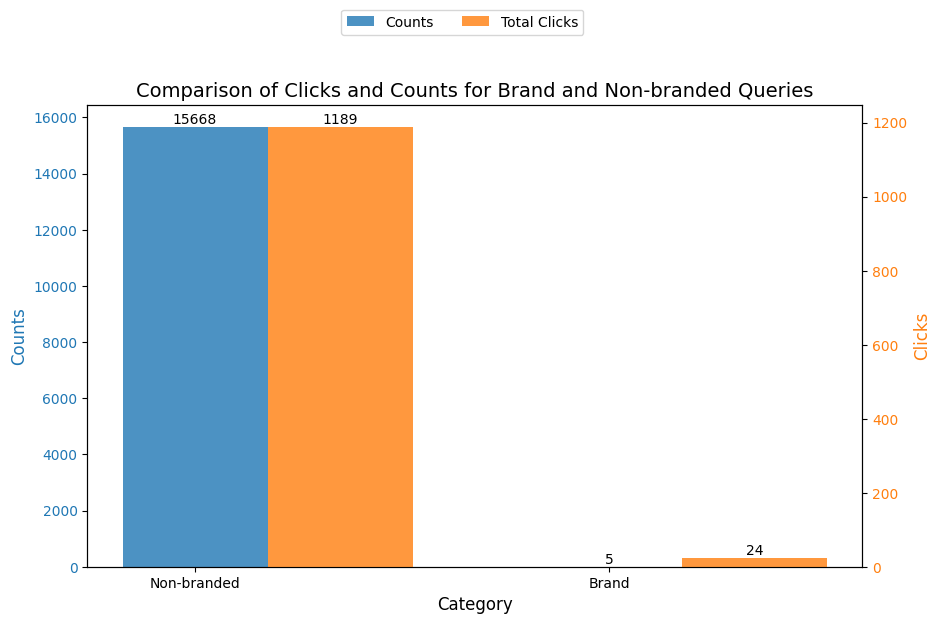

In [67]:
fig, ax1 = plt.subplots(figsize=(10, 6))  # Aumenta la dimensione per una migliore leggibilità

# Imposta lo stile del grafico
#plt.style.use('seaborn-v0_8-poster')

# Crea le posizioni delle barre
bar_width = 0.35
x_pos_counts = np.arange(len(brand_count_df.index))
x_pos_clicks = x_pos_counts + bar_width

# Crea l'asse Y1 per il numero di query (counts)
ax1.bar(x_pos_counts, brand_count_df['counts'], label='Counts', alpha=0.8, color='#1f77b4', width=bar_width)
ax1.set_xlabel('Category', fontsize=12)
ax1.set_ylabel('Counts', fontsize=12, color='#1f77b4')
ax1.tick_params(axis='y', labelcolor='#1f77b4')
ax1.set_xticks(x_pos_counts)
ax1.set_xticklabels(brand_count_df.index, fontsize=10)

# Crea un secondo asse Y per i click
ax2 = ax1.twinx()
ax2.bar(x_pos_clicks, brand_count_df['Total Clicks'], label='Total Clicks', alpha=0.8, color='#ff7f0e', width=bar_width)
ax2.set_ylabel('Clicks', fontsize=12, color='#ff7f0e')
ax2.tick_params(axis='y', labelcolor='#ff7f0e')

# Aggiungi le etichette dei valori
for i, val in enumerate(brand_count_df['counts']):
    ax1.annotate(f'{val:.0f}', (x_pos_counts[i], val), ha='center', va='bottom', fontsize=10)

for i, val in enumerate(brand_count_df['Total Clicks']):
    ax2.annotate(f'{val:.0f}', (x_pos_clicks[i], val), ha='center', va='bottom', fontsize=10)

# Aggiungi la legenda
fig.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=10)

# Titolo del grafico
plt.title('Comparison of Clicks and Counts for Brand and Non-branded Queries', fontsize=14)

# Salva il grafico con risoluzione più alta
plt.savefig(f'{new_output_dir}/{file_name}_clicks_and_count_brand_not_branded.png', bbox_inches='tight', dpi=300)

plt.show()
plt.close(fig)


In [68]:
# brand pie
###############################################################

# Metodo 2: Conteggio delle righe per la categoria "Brand"
brand_row_count = brand_count_df.loc[(brand_count_df.index == 'Brand') & (brand_count_df['counts'] >= 1), 'counts'].sum()

if brand_row_count == 0:
    print("La categoria 'Brand' ha zero righe.")
else:
    print(f"La categoria 'Brand' ha {brand_row_count} righe.")
    def create_pie_chart(data, labels, title, ax):
        explode = (0.1, 0)  # esplode la prima fetta
        #colors = ['orange', 'purple']  # usa colori personalizzati
        colors = ['#ff7f0e','#1f77b4']  # usa colori personalizzati
        ax.pie(data, explode=explode, labels=labels, autopct='%1.2f%%', shadow=True, colors=colors, startangle=140)
        ax.axis('equal')
        ax.set_title(title)

        fig, (axa, axb) = plt.subplots(1, 2, figsize=(12, 6))

        create_pie_chart(brand_count_df['counts'], brand_count_df.index, 'Counts for Brand and Non-Brand Queries', axa)
        create_pie_chart(brand_count_df['Total Clicks'], brand_count_df.index, 'Clicks for Brand and Non-Brand Queries', axb)

        # Aggiungi la firma
        axa.text(0.05, 0.05, 'by evemilano.com', transform=axa.transAxes, fontsize=10,
                verticalalignment='bottom', horizontalalignment='right', color='grey', alpha=0.5)

        # Mostra i grafici
        plt.tight_layout()
        #plt.savefig(f'{output_dir}/GSC_EXT_{property_name}_{now_str}_pie_graph.png')
        plt.savefig(f'{new_output_dir}/{file_name}_pie_graph.png')
        plt.show()
        plt.close(fig)



La categoria 'Brand' ha 5 righe.


In [69]:
# creazione database sole query BRAND e NO BRAND
#####################################
if brand_row_count > 0:
    #df_nobrand = raw_df.loc[raw_df['Brand/Non-branded'] == 'Non-branded']
    df_nobrand = raw_df.loc[raw_df['Brand/Non-branded'] == 'Non-branded'].copy()
    # Compila i valori vuoti
    df_nobrand.fillna(0, inplace = True)
    # Arrotonda i valori di posizione
    #df_nobrand['position'] = df_nobrand['position'].round().astype(int)
    df_nobrand.loc[:, 'weighted avg position'] = df_nobrand['weighted avg position'].round().astype(int)
    # Crea un dataframe per le query brand
    df_brand = raw_df.loc[raw_df['Brand/Non-branded'] == 'Brand']


    # Stampa la somma totale dei clicks e delle impressions
    total_clicks = df_brand['clicks'].sum()
    total_impressions = df_brand['impressions'].sum()

    print("Somma totale dei clicks:", total_clicks)
    print("Somma totale delle impressions:", total_impressions)




    print("Rows: " + str(df_brand.shape[0]))
    df_brand.head(12)
else: 
    print("La categoria 'Brand' ha zero righe.")
    df_nobrand = raw_df.copy()
    df_brand = pd.DataFrame()


Somma totale dei clicks: 25
Somma totale delle impressions: 528
Rows: 31


In [70]:
# vecchio metodo per il database delle query brand
# somma tutte le impression di query * URL (conta impressione e click anche dei sitelink)
# script bloccato da if False:
if False:
    # crea pivot brand (!)
    # Crea una copia del dataframe df_brand
    df_brand_pivot = df_brand.copy()
    # Elimina la colonna "page"
    df_brand_pivot.drop(columns=['page'], inplace=True)
    # Crea la pivot table


    # Creazione della tabella pivot
    pivot_b = df_brand_pivot.pivot_table(
        index='query', 
        values=['clicks', 'impressions', 'weighted avg position'], 
        aggfunc={
            'clicks': 'sum',
            'impressions': 'sum',
            'weighted avg position': lambda x: weighted_mean(x, df_brand_pivot.loc[x.index, 'impressions']),
        }
    )

    # Calcolo del CTR
    pivot_b['ctr'] = (pivot_b['clicks'] / pivot_b['impressions']) 

    # Riordina le colonne
    sorted_pivot = pivot_b.reindex(columns=['clicks', 'impressions', 'ctr', 'weighted avg position'])
    # Ordina la pivot table per 'impressions' in ordine decrescente
    sorted_pivot = sorted_pivot.sort_values(by='impressions', ascending=False)
    # Arrotonda i valori nella colonna 'position' e li converte in interi
    sorted_pivot['weighted avg position'] = sorted_pivot['weighted avg position'].round().astype(int)
    # Mostra le prime righe della pivot table
    print("Rows: " + str(sorted_pivot.shape[0]))

    sorted_pivot.head(5)


In [104]:
#df_brand

In [72]:
# pvt brand mantenendo solo la prima query per impression (rimuove i sitelink) come fa google search console

if brand_row_count == 0:
    print("La categoria 'Brand' ha zero righe.")
else:
    # Ordina il DataFrame per 'query' e 'impressions' in ordine decrescente
    df_brand_sorted = df_brand.sort_values(by=['query', 'impressions'], ascending=[True, False])

    # Rimuovi i duplicati, mantenendo solo la prima occorrenza (quella con il massimo di 'impressions')
    df_brand_unique = df_brand_sorted.drop_duplicates(subset='query')

    # Crea la pivot table
    pivot_b = df_brand_unique.pivot_table(
        index='query', 
        values=['clicks', 'impressions', 'weighted avg position'], 
        aggfunc={
            'clicks': 'sum',
            'impressions': 'sum',
            'weighted avg position': lambda x: weighted_mean(x, df_brand_unique.loc[x.index, 'impressions']),
        }
    )

    # Calcolo del CTR
    #pivot_b['ctr'] = (pivot_b['clicks'] / pivot_b['impressions']) * 100
    pivot_b['ctr'] = (pivot_b['clicks'] / pivot_b['impressions']) 

    # Riordina le colonne
    sorted_pivot = pivot_b.reindex(columns=['clicks', 'impressions', 'ctr', 'weighted avg position'])


    # Ordina la pivot table per 'impressions' in ordine decrescente
    sorted_pivot = sorted_pivot.sort_values(by='impressions', ascending=False)

    # Arrotonda i valori nella colonna 'weighted avg position' e li converte in interi
    sorted_pivot['weighted avg position'] = sorted_pivot['weighted avg position'].round().astype(int)



    # Stampa la somma totale dei clicks e delle impressions
    total_clicks = sorted_pivot['clicks'].sum()
    total_impressions = sorted_pivot['impressions'].sum()

    print("Somma totale dei clicks:", total_clicks)
    print("Somma totale delle impressions:", total_impressions)


    print("Rows: " + str(sorted_pivot.shape[0]))

    # Mostra le prime righe della pivot table
    # EXPORT PVT BRAND
    sorted_pivot.head(5)

Somma totale dei clicks: 24
Somma totale delle impressions: 235
Rows: 5


In [73]:
# Tabella Raw URL con pivot
# Crea una tabella pivot con multi-livello di indici
print('Creazione tabella pivot base URL')

# Crea una tabella pivot con multi-livello di indici
final_pivot_tableP = final_data.pivot_table(index=['page'], values=['clicks', 'impressions', 'position'], 
                                            aggfunc={
                                                'clicks': 'sum', 
                                                'impressions': 'sum', 
                                                'position': lambda x: weighted_mean(x, final_data.loc[x.index, 'impressions'])
                                            })
# Calcolo del CTR
final_pivot_tableP['ctr'] = (final_pivot_tableP['clicks'] / final_pivot_tableP['impressions']) 

# Ordina la tabella pivot in base alla somma di impressions
final_pivot_tableP.sort_values(by='impressions', axis=0, ascending=False, inplace=True)
final_pivot_tableP = final_pivot_tableP.rename(columns={'position': 'weighted avg position'})
final_pivot_tableP = final_pivot_tableP.reindex(columns=['clicks', 'impressions', 'ctr', 'weighted avg position'])

# Converte i valori di 'weighted avg position' da decimali a interi
final_pivot_tableP['weighted avg position'] = final_pivot_tableP['weighted avg position'].astype(int)

# Mostra la tabella pivot ordinata
# Stampa la somma totale dei clicks e delle impressions
total_clicks = final_pivot_tableP['clicks'].sum()
total_impressions = final_pivot_tableP['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

print("Rows: " + str(final_pivot_tableP.shape[0]))
final_pivot_tableP.head(10)

Creazione tabella pivot base URL
Somma totale dei clicks: 1221
Somma totale delle impressions: 200821
Rows: 807


,clicks,impressions,ctr,weighted avg position
page,,,,
https://www.evemilano.com/web-archive/,34,8643,0.39%,8
https://www.evemilano.com/proxy-server/,0,8558,0.00%,10
https://www.evemilano.com/servizi-web-marketing/,0,5613,0.00%,41
https://www.evemilano.com/gdpr/,0,5317,0.00%,12
https://www.evemilano.com/come-trovare-indirizzo-ip-sito-web/,67,4995,1.34%,16
https://www.evemilano.com/pubblicita-google/consulenza-adwords/,0,4270,0.00%,38
https://www.evemilano.com/guide-seo/motori-di-ricerca/,4,3829,0.10%,28
https://www.evemilano.com/servizi-seo/posizionamento-siti/,0,3802,0.00%,54
https://www.evemilano.com/servizi-seo/,0,3700,0.00%,51


In [74]:
# tabella raw query
# Crea una tabella pivot con multi-livello di indici
print('Creazione tabella pivot base QUERY')

# Crea una tabella pivot con multi-livello di indici
query_pivot_tableP = final_data.pivot_table(index=['query'], values=['clicks', 'impressions',  'position'], 
                                            aggfunc={
                                                'clicks': 'sum', 
                                                'impressions': 'sum', 
                                                'position': lambda x: weighted_mean(x, final_data.loc[x.index, 'impressions'])
                                            })

# Calcolo del CTR
print('Calcolo del CTR')
query_pivot_tableP['ctr'] = (query_pivot_tableP['clicks'] / query_pivot_tableP['impressions']) * 100

# Applica la formattazione alla colonna CTR
query_pivot_tableP['ctr'] = query_pivot_tableP['ctr'].apply(format_ctr)
# Converte i valori di 'weighted avg position' da decimali a interi
query_pivot_tableP['position'] = query_pivot_tableP['position'].astype(int)

# Ordina la tabella pivot in base alla somma di impressions
query_pivot_tableP.sort_values(by='impressions', axis=0, ascending=False, inplace=True)
query_pivot_tableP = query_pivot_tableP.reindex(columns=['clicks', 'impressions', 'ctr', 'position'])

# Rinomina la colonna 'ctr' in 'Weighted Average CTR' e 'position' in 'Weighted Average Position'
query_pivot_tableP = query_pivot_tableP.rename(columns={'position': 'weighted avg position'})

# Stampa la somma totale dei clicks e delle impressions
total_clicks = query_pivot_tableP['clicks'].sum()
total_impressions = query_pivot_tableP['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

# Mostra la tabella pivot ordinata
print("Rows: " + str(query_pivot_tableP.shape[0]))
query_pivot_tableP.head(3)


Creazione tabella pivot base QUERY
Calcolo del CTR
Somma totale dei clicks: 1221
Somma totale delle impressions: 200821
Rows: 15673


,clicks,impressions,ctr,weighted avg position
query,,,,
proxy,0,3810,0.00%,9
web archive,16,3735,0.43%,5
webarchive,8,2479,0.32%,4


In [75]:
# CALCOLO TABELLA WEBSITE CTR BY POS per chiavi NOBRAND
# Verifica il tipo di dati della colonna 'ctr'
if df_nobrand['ctr'].dtype == 'O':  # 'O' sta per 'object', che è tipicamente usato per le stringhe in pandas
    # Converti la colonna 'ctr' da percentuale (stringa) a float
    df_nobrand['ctr'] = df_nobrand['ctr'].str.rstrip('%').astype('float') / 100

# Funzione per calcolare la media ponderata
def weighted_mean(values, weights):
    return np.sum(values * weights) / np.sum(weights)

# Raggruppa per 'Weighted Avg Position' e calcola la media ponderata del CTR
query_analysis = df_nobrand.groupby('weighted avg position').apply(
    lambda x: weighted_mean(x['ctr'], x['impressions'])
).reset_index()

# Rinomina le colonne
query_analysis = query_analysis.rename(
    columns={0: 'website_avg_ctr_by_pos', 'weighted avg position': 'position'}
)

query_analysis['position'] = np.round(query_analysis['position'].astype(float).astype(int))

# Conta le query per ciascuna posizione in df_nobrand
query_count = df_nobrand.groupby('weighted avg position').size().reset_index(name='query_count')

# Converti 'Weighted Avg Position' in valori interi per il merge
query_count['weighted avg position'] = np.round(query_count['weighted avg position'].astype(float) ).astype(int)

# Aggiungi la colonna query_count a query_analysis
query_analysis = query_analysis.merge(query_count, left_on='position', right_on='weighted avg position', how='left')

# Rimuovi la colonna aggiuntiva 'Weighted Avg Position' risultante dal merge
query_analysis.drop('weighted avg position', axis=1, inplace=True)

# Ordina i risultati per 'position'
query_analysis.sort_values(by='position', ascending=True, inplace=True)

# Visualizza i risultati
query_analysis.head(10)


,position,website_avg_ctr_by_pos,query_count
0,1,11.26%,781
1,2,8.10%,357
2,3,5.17%,420
3,4,0.97%,435
4,5,0.80%,426
5,6,1.21%,455
6,7,0.48%,396
7,8,0.13%,411
8,9,0.22%,404
9,10,0.15%,472


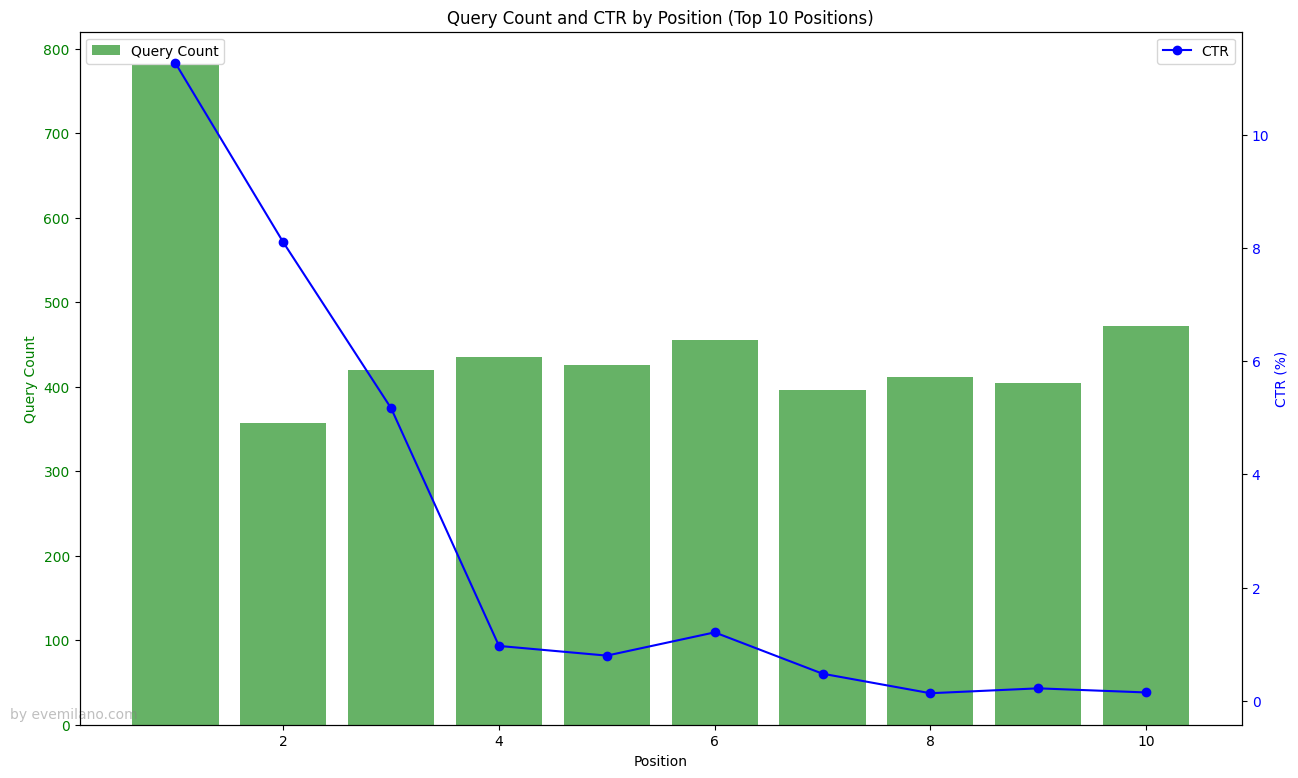

In [76]:
# gfx test 2 invertito

# Assumi che query_analysis sia già definito e caricato

# Assicurati che il DataFrame sia ordinato in base alla 'position'
query_analysis = query_analysis.sort_values(by='position')

# Seleziona solo le prime 10 posizioni
top_10_query_analysis = query_analysis.head(10)

# Imposta le dimensioni del grafico
plt.figure(figsize=(15, 9))

# Crea l'asse per il conteggio delle query
ax1 = plt.gca()  # Get current axis
ax1.bar(top_10_query_analysis['position'], top_10_query_analysis['query_count'], color='g', alpha=0.6, label='Query Count')
ax1.set_xlabel('Position')
ax1.set_ylabel('Query Count', color='g')
ax1.tick_params(axis='y', labelcolor='g')

# Crea un secondo asse per il CTR
ax2 = ax1.twinx()  # Crea un secondo asse che condivide lo stesso asse x
ax2.plot(top_10_query_analysis['position'], top_10_query_analysis['website_avg_ctr_by_pos'] * 100, color='b', marker='o', label='CTR')
ax2.set_ylabel('CTR (%)', color='b')
ax2.tick_params(axis='y', labelcolor='b')

# Aggiungi titoli e legenda
plt.title('Query Count and CTR by Position (Top 10 Positions)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Aggiungi la firma
ax1.text(0.05, 0.005, 'by evemilano.com', transform=ax1.transAxes, fontsize=10,
        verticalalignment='bottom', horizontalalignment='right', color='grey', alpha=0.5)

# Salva l'immagine
file_name = 'output_file_name'  # Sostituisci con il nome del file di output desiderato
plt.savefig(f'{new_output_dir}/{file_name}_query_count_and_ctr_by_position.png', bbox_inches='tight')
# Mostra il grafico
plt.show()
# Chiudi la figura per liberare memoria
plt.close()

In [77]:
# file raw scaricabile con posizione media del sito web
raw_dfP = final_pivot_tableP.copy()
raw_dfP = raw_dfP.reset_index()
# Assicurati che la colonna 'position' in query_analysis sia dello stesso tipo di 'weighted avg position' in raw_dfP
query_analysis['position'] = query_analysis['position'].astype(int)

# Crea un dizionario per il mapping
ctr_mapping = dict(zip(query_analysis['position'], query_analysis['website_avg_ctr_by_pos']))

# Applica il mapping
raw_dfP['website_avg_ctr_by_pos'] = raw_dfP['weighted avg position'].map(ctr_mapping)

# Verifica se ci sono valori mancanti (NaN) e il motivo
missing_positions = raw_dfP[raw_dfP['website_avg_ctr_by_pos'].isna()]['weighted avg position'].unique()
print("Missing positions in mapping:", missing_positions)

# Stampa la somma totale dei clicks e delle impressions
total_clicks = raw_dfP['clicks'].sum()
total_impressions = raw_dfP['impressions'].sum()
print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)
# Visualizza il risultato
raw_dfP.head(10)


Missing positions in mapping: []
Somma totale dei clicks: 1221
Somma totale delle impressions: 200821


,page,clicks,impressions,ctr,weighted avg position,website_avg_ctr_by_pos
0,https://www.evemilano.com/web-archive/,34,8643,0.39%,8,0.13%
1,https://www.evemilano.com/proxy-server/,0,8558,0.00%,10,0.15%
2,https://www.evemilano.com/servizi-web-marketing/,0,5613,0.00%,41,2.50%
3,https://www.evemilano.com/gdpr/,0,5317,0.00%,12,0.13%
4,https://www.evemilano.com/come-trovare-indiriz...,67,4995,1.34%,16,0.15%
5,https://www.evemilano.com/pubblicita-google/co...,0,4270,0.00%,38,0.00%
6,https://www.evemilano.com/guide-seo/motori-di-...,4,3829,0.10%,28,0.24%
7,https://www.evemilano.com/servizi-seo/posizion...,0,3802,0.00%,54,0.00%
8,https://www.evemilano.com/servizi-seo/,0,3700,0.00%,51,0.00%
9,https://www.evemilano.com/servizi-seo/agenzia/,0,2848,0.00%,74,0.00%


In [78]:
# Funzione per confrontare i CTR
def compare_ctr(row):
    if row['ctr'] > row['website_avg_ctr_by_pos']:
        return 'greater'
    elif row['ctr'] < row['website_avg_ctr_by_pos']:
        return 'lower'
    else:
        return 'equal'

# Applica la funzione a ciascuna riga per creare la colonna 'comparison'
raw_dfP['comparison'] = raw_dfP.apply(compare_ctr, axis=1)

print("Rows: " + str(raw_dfP.shape[0]))
# Specifica il nuovo ordine delle colonne
new_columns_order = ['page', 'clicks', 'impressions', 'ctr', 'website_avg_ctr_by_pos', 'comparison', 'weighted avg position']

# Stampa la somma totale dei clicks e delle impressions
total_clicks = raw_dfP['clicks'].sum()
total_impressions = raw_dfP['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

# Riordina le colonne in raw_dfP
raw_dfP = raw_dfP.reindex(columns=new_columns_order)

raw_dfP.head(3)

Rows: 807
Somma totale dei clicks: 1221
Somma totale delle impressions: 200821


,page,clicks,impressions,ctr,website_avg_ctr_by_pos,comparison,weighted avg position
0,https://www.evemilano.com/web-archive/,34,8643,0.39%,0.13%,greater,8
1,https://www.evemilano.com/proxy-server/,0,8558,0.00%,0.15%,lower,10
2,https://www.evemilano.com/servizi-web-marketing/,0,5613,0.00%,2.50%,lower,41


In [79]:
# Tabella pivot con le cartelle di primo livello
print('Creazione tabella pivot con le cartelle di primo livello')
# Definisci una funzione lambda per estrarre la cartella di primo livello dall'URL
get_first_level_folder = lambda url: url.split('/')[3]

# Crea una nuova colonna nel dataframe con la cartella di primo livello per ogni URL
raw_dfP['first_level_folder'] = raw_dfP['page'].apply(get_first_level_folder)

# Raggruppa il dataframe in base alla cartella di primo livello e calcola le somme di 'clicks' e 'impressions' e il conteggio degli URL
trending_folders = raw_dfP.groupby('first_level_folder').agg({'clicks': 'sum', 'impressions': 'sum', 'page': 'count'})

# Rinomina la colonna 'page' in 'count'
trending_folders.rename(columns={'page': 'url_count'}, inplace=True)

# Calcola CTR medio
trending_folders['ctr'] = trending_folders['clicks'] / trending_folders['impressions']

# Utilizza .loc per creare nuove colonne
trending_folders.loc[:, 'click/URL'] = trending_folders['clicks'] / trending_folders['url_count']
trending_folders.loc[:, 'imp/URL'] = trending_folders['impressions'] / trending_folders['url_count']

# Ordina il dataframe risultante in base alle impressions
trending_folders.sort_values('url_count', ascending=False, inplace=True)

# cancella righe se non hanno almeno 2 URL in cartella
trending_folders = trending_folders[trending_folders['url_count'] >= 2]

# Stampa la somma totale dei clicks e delle impressions
total_clicks = trending_folders['clicks'].sum()
total_impressions = trending_folders['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

trending_folders

Creazione tabella pivot con le cartelle di primo livello
Somma totale dei clicks: 701
Somma totale delle impressions: 123567


,clicks,impressions,url_count,ctr,click/URL,imp/URL
first_level_folder,,,,,,
come-funzionano-le-espressioni-regolari-regex,33,2362,13,1.40%,253.85%,18169.23%
servizi-seo,2,17058,13,0.01%,15.38%,131215.38%
pagerank,0,897,11,0.00%,0.00%,8154.55%
corsi,1,4850,11,0.02%,9.09%,44090.91%
redirect,9,2678,11,0.34%,81.82%,24345.45%
...,...,...,...,...,...,...
esempi-mod-rewrite-htaccess-apache,7,477,3,1.47%,233.33%,15900.00%
disavow-tool,0,183,3,0.00%,0.00%,6100.00%
infinite-scroll,1,82,3,1.22%,33.33%,2733.33%


In [80]:
# Applico filtri al dataframe nobrand
##########################################
# rimuovo le query deboli

# formattazione position

# opzioni impostate a inizio script position e impressions
#df_new = df_nobrand.loc[(raw_df['Weighted Avg Position'] <= max_pos) & (raw_df['impressions'] >= min_imp),:]
df_new = df_nobrand.loc[(raw_df['weighted avg position'] <= max_pos) & (raw_df['impressions'] >= min_imp),:].copy()


# Rimuovi il simbolo di percentuale e converti in float, poi in int
df_new['weighted avg position'] = df_new['weighted avg position'].astype(int)

# rinomina colonna position
df_new = df_new.rename(columns={'weighted avg position': 'position'})

# ordino i dati per impressioni e click
df_new = df_new.sort_values(by=['impressions', 'clicks'],ascending=False)

if 'match_queries' in df_new.columns:
    df_new = df_new.drop(columns=['match_queries'])

# Stampa la somma totale dei clicks e delle impressions
total_clicks = df_new['clicks'].sum()
total_impressions = df_new['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

print(df_new.shape[0])
df_new.head(3)

Somma totale dei clicks: 218
Somma totale delle impressions: 63702
211


,query,page,clicks,impressions,ctr,position,Char,Stemming,Stems Ordered by frequency,Strongest word stem,Lemmatized,Lemmas Ordered by frequency,Strongest lemma,spacy_nouns,Brand/Non-branded
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,0.00%,8,5,proxy,proxy,proxy,proxy,proxy,proxy,proxy,Non-branded
1,web archive,https://www.evemilano.com/web-archive/,16,3735,0.43%,4,11,web archiv,web archiv,web,web archive,web archive,web,web,Non-branded
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,0.32%,4,10,webarc,webarc,webarc,Webarchive,Webarchive,Webarchive,webarchive,Non-branded


In [127]:
# implementa colonna avg_ctr_by_pos e comparison
##################################################

# Assicurati che 'position' in df_new e 'position' in query_analysis siano dello stesso tipo di dati
df_new['position'] = df_new['position'].astype(int)
query_analysis['position'] = query_analysis['position'].astype(int)

# Crea un dizionario per il mapping da query_analysis
ctr_mapping = dict(zip(query_analysis['position'], query_analysis['website_avg_ctr_by_pos']))

merged_df=df_new.copy()
# Applica il mapping per ottenere 'wwebsite_avg_ctr_by_pos' in df_new
merged_df['website_avg_ctr_by_pos'] = merged_df['position'].map(ctr_mapping)

# Applica la funzione a ciascuna riga per creare la colonna 'comparison'
merged_df['comparison'] = merged_df.apply(compare_ctr, axis=1)

# Visualizza il DataFrame aggiornato
merged_df.head()


,query,page,clicks,impressions,ctr,position,Char,Stemming,Stems Ordered by frequency,Strongest word stem,Lemmatized,Lemmas Ordered by frequency,Strongest lemma,spacy_nouns,Brand/Non-branded,website_avg_ctr_by_pos,comparison
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,0.00%,8,5,proxy,proxy,proxy,proxy,proxy,proxy,proxy,Non-branded,0.13%,lower
1,web archive,https://www.evemilano.com/web-archive/,16,3735,0.43%,4,11,web archiv,web archiv,web,web archive,web archive,web,web,Non-branded,0.97%,lower
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,0.32%,4,10,webarc,webarc,webarc,Webarchive,Webarchive,Webarchive,webarchive,Non-branded,0.97%,lower
3,gdpr significato,https://www.evemilano.com/gdpr/,0,2420,0.00%,8,16,gdpr signific,signific gdpr,signific,gdpr significato,significato gdpr,significato,gdpr,Non-branded,0.13%,lower
4,l'indirizzo completo di un sito,https://www.evemilano.com/come-trovare-indiriz...,0,1681,0.00%,9,31,l'indirizz complet sit,sit l'indirizz complet,sit,indirizzo completo sito,sito indirizzo completo,sito,indirizzo sito,Non-branded,0.22%,lower


In [128]:
# crea 3 colonne con split URL path
###################################
# crea copia db
merged_df4 = merged_df.copy()
# funzione per splittare url ad ogni /
def extract_folders(url):
    try:
        # Utilizziamo un'espressione regolare per estrarre le cartelle logiche dall'URL
        match = re.match(r'https?://[^/]+(/.*)', url)
        if match:
            path = match.group(1)
            folders = path.split('/')
            # Se l'URL ha meno di 3 cartelle, aggiungiamo le cartelle mancanti
            while len(folders) < 3:
                folders.append('')
            # Restituiamo la lista di cartelle
            return folders
        else:
            # L'URL non ha un percorso valido, restituisci una lista vuota
            return [''] * 3
    except:
        # In caso di errore, restituisci una lista vuota
        print(f"Errore: Impossibile estrarre cartelle da {url}")
        return [''] * 3

# Creiamo le nuove colonne del DataFrame utilizzando il metodo apply
folders = merged_df4['page'].apply(extract_folders)
merged_df4['folder_lv1'] = folders.apply(lambda x: x[1] if len(x) > 1 else '')
merged_df4['folder_lv2'] = folders.apply(lambda x: x[2] if len(x) > 2 else '')
merged_df4['folder_lv3'] = folders.apply(lambda x: x[3] if len(x) > 3 else '')
merged_df4['folder_lv4'] = folders.apply(lambda x: x[4] if len(x) > 4 else '')
print(merged_df4.shape[0])
merged_df4.head(3)

211


,query,page,clicks,impressions,ctr,position,Char,Stemming,Stems Ordered by frequency,Strongest word stem,...,Lemmas Ordered by frequency,Strongest lemma,spacy_nouns,Brand/Non-branded,website_avg_ctr_by_pos,comparison,folder_lv1,folder_lv2,folder_lv3,folder_lv4
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,0.00%,8,5,proxy,proxy,proxy,...,proxy,proxy,proxy,Non-branded,0.13%,lower,proxy-server,,,
1,web archive,https://www.evemilano.com/web-archive/,16,3735,0.43%,4,11,web archiv,web archiv,web,...,web archive,web,web,Non-branded,0.97%,lower,web-archive,,,
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,0.32%,4,10,webarc,webarc,webarc,...,Webarchive,Webarchive,webarchive,Non-branded,0.97%,lower,web-archive,,,


In [129]:
# aggiungi colonna con 5 termini più frequenti per l'URL
########################################################
# copia db
merged_df5 = merged_df4.copy()
# crea una nuova colonna vuota
merged_df5 = merged_df5.assign(top_5_queries='')

# per ogni URL mostra le 5 parole chiave con maggiori impressioni
df_grouped = merged_df5.groupby('page').apply(lambda x: x.nlargest(5, 'impressions')['query'].tolist())
# crea nuova colonna top_5_queries
merged_df5['top_5_queries'] = merged_df5['page'].map(df_grouped)
# unisci le 5 parole chiave in una stringa separata da virgola

total_rows = merged_df5.shape[0]
for i, row in merged_df5.iterrows():
    progress = f"Processing row {i+1}/{total_rows}"
    print(progress, end='\r')
    merged_df5.at[i, 'top_5_queries'] = ', '.join(row['top_5_queries'])

# trasforma il valore posizione in intero
merged_df5['position'] = merged_df5['position'].astype(int)

print("Processing completed.")
merged_df5.head(3)

Processing completed.1


,query,page,clicks,impressions,ctr,position,Char,Stemming,Stems Ordered by frequency,Strongest word stem,...,Strongest lemma,spacy_nouns,Brand/Non-branded,website_avg_ctr_by_pos,comparison,folder_lv1,folder_lv2,folder_lv3,folder_lv4,top_5_queries
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,0.00%,8,5,proxy,proxy,proxy,...,proxy,proxy,Non-branded,0.13%,lower,proxy-server,,,,"proxy, proxy significato, proxy server, proxy ..."
1,web archive,https://www.evemilano.com/web-archive/,16,3735,0.43%,4,11,web archiv,web archiv,web,...,web,web,Non-branded,0.97%,lower,web-archive,,,,"web archive, webarchive, archive web, internet..."
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,0.32%,4,10,webarc,webarc,webarc,...,Webarchive,webarchive,Non-branded,0.97%,lower,web-archive,,,,"web archive, webarchive, archive web, internet..."


In [148]:
# riorganizza le colonne FINAL OUTPUT
final_df = merged_df5.copy()
# Crea una lista delle colonne nell'ordine desiderato
column_order = ["query", "Char", "page", "clicks", "impressions", "position", "ctr","website_avg_ctr_by_pos", "comparison", "Strongest word stem","Strongest lemma", "spacy_nouns","top_5_queries","folder_lv1","folder_lv2","folder_lv3","Brand/Non-branded"]


# Utilizza il metodo reindex per riordinare le colonne del dataframe
final_df = final_df.reindex(columns=column_order)
#final_df.head(5)

In [149]:
# Stampa la somma totale dei clicks e delle impressions
total_clicks = final_df['clicks'].sum()
total_impressions = final_df['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)

final_df

Somma totale dei clicks: 218
Somma totale delle impressions: 63702


,query,Char,page,clicks,impressions,position,ctr,website_avg_ctr_by_pos,comparison,Strongest word stem,Strongest lemma,spacy_nouns,top_5_queries,folder_lv1,folder_lv2,folder_lv3,Brand/Non-branded
0,proxy,5,https://www.evemilano.com/proxy-server/,0,3810,8,0.00%,0.13%,lower,proxy,proxy,proxy,"proxy, proxy significato, proxy server, proxy ...",proxy-server,,,Non-branded
1,web archive,11,https://www.evemilano.com/web-archive/,16,3735,4,0.43%,0.97%,lower,web,web,web,"web archive, webarchive, archive web, internet...",web-archive,,,Non-branded
2,webarchive,10,https://www.evemilano.com/web-archive/,8,2479,4,0.32%,0.97%,lower,webarc,Webarchive,webarchive,"web archive, webarchive, archive web, internet...",web-archive,,,Non-branded
3,gdpr significato,16,https://www.evemilano.com/gdpr/,0,2420,8,0.00%,0.13%,lower,signific,significato,gdpr,"gdpr significato, gdpr acronimo, gdpr, gdpr, a...",gdpr,,,Non-branded
4,l'indirizzo completo di un sito,31,https://www.evemilano.com/come-trovare-indiriz...,0,1681,9,0.00%,0.22%,lower,sit,sito,indirizzo sito,"l'indirizzo completo di un sito, l'indirizzo d...",come-trovare-indirizzo-ip-sito-web,,,Non-branded
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,google advertising,18,https://www.evemilano.com/pubblicita-google/,0,101,94,0.00%,0.00%,equal,googl,google,advertising,"pubblicità su google, pubblicità google, googl...",pubblicita-google,,,Non-branded
207,servizio link building,22,https://www.evemilano.com/servizi-seo/link-bui...,0,101,27,0.00%,0.00%,equal,link,link,servizio link,"link building, agenzia link building, servizio...",servizi-seo,link-building,,Non-branded
209,alerts,6,https://www.evemilano.com/google-alerts/,0,101,13,0.00%,0.30%,lower,alerts,alerts,alerts,alerts,google-alerts,,,Non-branded
210,gestione blog aziendale,23,https://www.evemilano.com/blog-aziendali-wordp...,0,100,39,0.00%,0.95%,lower,blog,blog,gestione blog,"blog aziendale, blog aziendali, gestione blog ...",blog-aziendali-wordpress,,,Non-branded


In [150]:
# Cannibalizzazione
df_cann = final_df.copy()
# Calcola la somma delle 'impressions' per ogni 'query'
impressions_sums = df_cann.groupby('query')['impressions'].sum()
# Crea una nuova colonna nel DataFrame per queste somme
df_cann['impressions_sum'] = df_cann['query'].map(impressions_sums)
# Crea la tabella pivot utilizzando anche la nuova colonna
cann_pivot_table = df_cann.pivot_table(index=['query', 'page'], values=['clicks', 'impressions', 'ctr', 'position', 'impressions_sum'])
# Ordina le righe in base alla somma delle 'impressions', quindi in base alle 'impressions' per pagina
cann_pivot_table_sorted = cann_pivot_table.sort_values(['impressions_sum', 'impressions','query'], ascending=[False, False, False])
# Filtra le righe per mostrare solo le query che appaiono almeno due volte
cann_filtered_table = cann_pivot_table_sorted.groupby('query').filter(lambda x: len(x) > 1)
# Imposta l'opzione 'multi_sparse' su False per ripetere query in ogni riga
pd.set_option('display.multi_sparse', False)
# Rimuovi la colonna 'impressions_sum'
cann_filtered_table = cann_filtered_table.drop(columns='impressions_sum')
# ordina e formatta
cann_filtered_table = cann_filtered_table.sort_values(by=['query', 'page', 'clicks', 'impressions', 'ctr', 'position'])
# Formatta 'clicks', 'impressions', e 'position' come interi
cann_filtered_table['clicks'] = cann_filtered_table['clicks'].astype(int)
cann_filtered_table['impressions'] = cann_filtered_table['impressions'].astype(int)
cann_filtered_table['position'] = cann_filtered_table['position'].astype(int)
# Formatta 'ctr' con 5 decimali
# Visualizza il DataFrame aggiornato
cann_filtered_table.head(10)

,,clicks,ctr,impressions,position
query,page,,,,
consulenza seo,https://www.evemilano.com/,0,0.00%,239,67
consulenza seo,https://www.evemilano.com/servizi-seo/,0,0.00%,508,85


In [152]:
# Foglio Improve, solo posizioni > 6
df_improve = final_df.copy()
df_improve = df_improve[df_improve['position'] >= 6]
# rimuovi colonne inutili
df_improve = df_improve.drop(columns=['website_avg_ctr_by_pos', 'Brand/Non-branded', 'comparison','top_5_queries','Strongest word stem','Strongest lemma','spacy_nouns','folder_lv1', 'folder_lv2', 'folder_lv3'])
# Stampa la somma totale dei clicks e delle impressions
total_clicks = df_improve['clicks'].sum()
total_impressions = df_improve['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)
df_improve

Somma totale dei clicks: 110
Somma totale delle impressions: 51832


,query,Char,page,clicks,impressions,position,ctr
0,proxy,5,https://www.evemilano.com/proxy-server/,0,3810,8,0.00%
3,gdpr significato,16,https://www.evemilano.com/gdpr/,0,2420,8,0.00%
4,l'indirizzo completo di un sito,31,https://www.evemilano.com/come-trovare-indiriz...,0,1681,9,0.00%
5,agenzia seo,11,https://www.evemilano.com/servizi-seo/agenzia/,0,1624,91,0.00%
6,gdpr acronimo,13,https://www.evemilano.com/gdpr/,0,1420,10,0.00%
...,...,...,...,...,...,...,...
206,google advertising,18,https://www.evemilano.com/pubblicita-google/,0,101,94,0.00%
207,servizio link building,22,https://www.evemilano.com/servizi-seo/link-bui...,0,101,27,0.00%
209,alerts,6,https://www.evemilano.com/google-alerts/,0,101,13,0.00%
210,gestione blog aziendale,23,https://www.evemilano.com/blog-aziendali-wordp...,0,100,39,0.00%


In [153]:
# Funzione per ottenere un User-Agent casuale   
def get_random_user_agent():
    ua = UserAgent()
    if user_agent_option == 'random':
        return ua.random
    elif user_agent_option == 'chrome':
        return ua.chrome
    elif user_agent_option == 'fixed':
        return 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'
    else:
        print("Opzione User-Agent non valida. Utilizzo di un User-Agent casuale.")
        return ua.random
    
# Funzione per estrarre il tag title da un URL
def extract_title(url, session):
    headers = {'User-Agent': get_random_user_agent()}
    try:
        response = session.get(url, headers=headers)
        response.raise_for_status()
        if 'text/html' not in response.headers.get('Content-Type', ''):
            print(f"Skipping non-HTML content at {url}")
            return None
        #soup = BeautifulSoup(response.content, 'html.parser')

        try:
            soup = BeautifulSoup(response.content, 'html.parser', from_encoding=response.encoding)
            print(headers)
        except Exception as e:
            print(f"Error Details:")
            print(f"  - URL: {url}")
            print(f"  - Exception Type: {type(e).__name__}")
            print(f"  - Exception Message: {str(e)}")
            if hasattr(e, 'response') and e.response is not None:
                print(f"  - HTTP Status Code: {e.response.status_code}")
                print(f"  - HTTP Headers: {e.response.headers}")

        title_tag = soup.find('title')
        return title_tag.get_text().strip() if title_tag else None
    except requests.exceptions.RequestException as e:
        print(f"Error accessing {url}: {e}")
        return None

# Funzione per aggiornare raw_dfP con il tag title
def update_raw_df_with_titles(raw_dfP, counter_max, include="", exclude=""):
    # Converti le stringhe include ed exclude in liste, se non sono vuote
    include_list = None if not include else include.split("|")
    exclude_list = exclude.split("|") if exclude else None

    session = requests.Session()
    raw_dfP['tag title'] = ''
    counter = 0
    total_requests = min(counter_max, len(raw_dfP))  # Il minimo tra counter_max e la lunghezza di raw_dfP
    for i, row in raw_dfP.iterrows():
        url = row['page']
        # Se include_list è None, ignora il filtro di inclusione
        should_include = include_list is None or any(folder in url for folder in include_list)
        should_exclude = exclude_list is not None and any(folder in url for folder in exclude_list)

        # Aggiungi stampe di debug per verificare il processo di filtraggio
        print(f"Debug - URL: {url} - Debug - Include: {should_include} - Exclude: {should_exclude}")

        # Incrementa il contatore solo se l'URL rispetta i criteri di include ed exclude
        if should_include and not should_exclude:
            if counter >= counter_max:
                break
            title = extract_title(url, session)
            if title:
                raw_dfP.at[i, 'tag title'] = title
            print(f'Request {counter+1}/{total_requests} - {url} - {raw_dfP.at[i, "tag title"]}')
            counter += 1
            time.sleep(attesa)  # Rate limiting
    session.close()
    return raw_dfP

# Funzione per eseguire il VLOOKUP-like operation
def vlookup_titles_into_merged_df(merged_df7, raw_dfP):
    # Creare un dizionario di URL e tag title da raw_dfP
    title_dict = pd.Series(raw_dfP['tag title'].values, index=raw_dfP['page']).to_dict()
    # Mappare il tag title su merged_df7 usando il dizionario
    merged_df7['tag title'] = merged_df7['page'].map(title_dict)
    return merged_df7

# Eseguire le operazioni
# Aggiorna raw_dfP con i tag title, passando le variabili include ed exclude
raw_dfP = update_raw_df_with_titles(raw_dfP, counter_max, include, exclude)

merged_df7= final_df.copy()

# Unire i tag title in merged_df7
merged_df7 = vlookup_titles_into_merged_df(merged_df7, raw_dfP)

# Visualizzare le prime righe per confermare
merged_df7.head()


Debug - URL: https://www.evemilano.com/web-archive/ - Debug - Include: True - Exclude: False
{'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/119.0.0.0 Safari/537.36'}
Request 1/1 - https://www.evemilano.com/web-archive/ - Cos’è Web Archive? Scopri i suoi utilizzi pratici
Debug - URL: https://www.evemilano.com/proxy-server/ - Debug - Include: True - Exclude: False


,query,Char,page,clicks,impressions,position,ctr,website_avg_ctr_by_pos,comparison,Strongest word stem,Strongest lemma,spacy_nouns,top_5_queries,folder_lv1,folder_lv2,folder_lv3,Brand/Non-branded,tag title
0,proxy,5,https://www.evemilano.com/proxy-server/,0,3810,8,0.00%,0.13%,lower,proxy,proxy,proxy,"proxy, proxy significato, proxy server, proxy ...",proxy-server,,,Non-branded,
1,web archive,11,https://www.evemilano.com/web-archive/,16,3735,4,0.43%,0.97%,lower,web,web,web,"web archive, webarchive, archive web, internet...",web-archive,,,Non-branded,Cos’è Web Archive? Scopri i suoi utilizzi pratici
2,webarchive,10,https://www.evemilano.com/web-archive/,8,2479,4,0.32%,0.97%,lower,webarc,Webarchive,webarchive,"web archive, webarchive, archive web, internet...",web-archive,,,Non-branded,Cos’è Web Archive? Scopri i suoi utilizzi pratici
3,gdpr significato,16,https://www.evemilano.com/gdpr/,0,2420,8,0.00%,0.13%,lower,signific,significato,gdpr,"gdpr significato, gdpr acronimo, gdpr, gdpr, a...",gdpr,,,Non-branded,
4,l'indirizzo completo di un sito,31,https://www.evemilano.com/come-trovare-indiriz...,0,1681,9,0.00%,0.22%,lower,sit,sito,indirizzo sito,"l'indirizzo completo di un sito, l'indirizzo d...",come-trovare-indirizzo-ip-sito-web,,,Non-branded,


In [135]:
# Funzione per verificare la presenza delle parole chiave
def check_keywords_in_title(row):
    # Rimuovi la punteggiatura dalle parole chiave e convertile in minuscolo, poi rimuovi le stopwords.
    keywords = set(word.lower().strip(string.punctuation) for phrase in row['top_5_queries'].split(',') 
                   for word in phrase.lower().split() if word.lower().strip(string.punctuation) not in stopwords)
    
    # Rimuovi la punteggiatura dal titolo, convertilo in minuscolo e rimuovi le stopwords.
    title_words = set(word.lower().strip(string.punctuation) for word in row['tag title'].split() 
                      if word.lower().strip(string.punctuation) not in stopwords) \
                  if pd.notnull(row['tag title']) else set()
    
    # Se il titolo è vuoto, restituisci 'N.A.'
    if not title_words:
        return 'N.A.'

    # Trova quali parole chiave mancano nel titolo
    missing = keywords - title_words

    # Restituisci il risultato appropriato
    if not missing:
        return 'Ok'
    else:
        return f"Missing {len(missing)}: {', '.join(missing)}"

# Applica la funzione a ciascuna riga del DataFrame e crea la colonna 'check'
merged_df7['check'] = merged_df7.apply(check_keywords_in_title, axis=1)

# Mostra le prime righe per confermare che la colonna 'check' è stata creata correttamente
merged_df7.head()



,query,Char,page,clicks,impressions,position,ctr,website_avg_ctr_by_pos,comparison,Ordered by frequency,Strongest word stem,spacy_nouns,top_5_queries,folder_lv1,folder_lv2,folder_lv3,Brand/Non-branded,tag title,check
0,proxy,5,https://www.evemilano.com/proxy-server/,0,3810,8,0.00%,0.13%,lower,NaN,proxy,proxy,"proxy, proxy significato, proxy server, proxy ...",proxy-server,,,Non-branded,,N.A.
1,web archive,11,https://www.evemilano.com/web-archive/,16,3735,4,0.43%,0.97%,lower,NaN,web,web,"web archive, webarchive, archive web, internet...",web-archive,,,Non-branded,Cos’è Web Archive? Scopri i suoi utilizzi pratici,"Missing 3: web.archive, webarchive, internet"
2,webarchive,10,https://www.evemilano.com/web-archive/,8,2479,4,0.32%,0.97%,lower,NaN,webarc,webarchive,"web archive, webarchive, archive web, internet...",web-archive,,,Non-branded,Cos’è Web Archive? Scopri i suoi utilizzi pratici,"Missing 3: web.archive, webarchive, internet"
3,gdpr significato,16,https://www.evemilano.com/gdpr/,0,2420,8,0.00%,0.13%,lower,NaN,signific,gdpr,"gdpr significato, gdpr acronimo, gdpr, gdpr, a...",gdpr,,,Non-branded,,N.A.
4,l'indirizzo completo di un sito,31,https://www.evemilano.com/come-trovare-indiriz...,0,1681,9,0.00%,0.22%,lower,NaN,sit,indirizzo sito,"l'indirizzo completo di un sito, l'indirizzo d...",come-trovare-indirizzo-ip-sito-web,,,Non-branded,,N.A.


In [136]:
# riorganizza colonne del foglio "Check tag title"
# Crea una lista delle colonne nell'ordine desiderato
column_order = ["query", "page", "clicks", "impressions", "position", "ctr","website_avg_ctr_by_pos","comparison", "Brand/Non-branded","top_5_queries","tag title","check",]
merged_df8 = merged_df7.reindex(columns=column_order)

In [137]:
# conta caratteri
# Creare la nuova colonna "tag title length" con la lunghezza della stringa in "tag title"
merged_df8.insert(merged_df8.columns.get_loc("tag title")+1, "tag title len", merged_df8["tag title"].apply(lambda x: len(str(x))))
merged_df8.head(3)

,query,page,clicks,impressions,position,ctr,website_avg_ctr_by_pos,comparison,Brand/Non-branded,top_5_queries,tag title,tag title len,check
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,8,0.00%,0.13%,lower,Non-branded,"proxy, proxy significato, proxy server, proxy ...",,0,N.A.
1,web archive,https://www.evemilano.com/web-archive/,16,3735,4,0.43%,0.97%,lower,Non-branded,"web archive, webarchive, archive web, internet...",Cos’è Web Archive? Scopri i suoi utilizzi pratici,49,"Missing 3: web.archive, webarchive, internet"
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,4,0.32%,0.97%,lower,Non-branded,"web archive, webarchive, archive web, internet...",Cos’è Web Archive? Scopri i suoi utilizzi pratici,49,"Missing 3: web.archive, webarchive, internet"


In [138]:
# ottieni tag title da gpt
#################################
# setup richiesta gtp
# nuovo dataframe
merged_df8b = merged_df8.copy()

# creo dizionario delle risposte di gpt per evitare chiamate doppie
gpt_responses = {}
# Inizializza un contatore per il numero totale di token
total_tokens_used = 0
# Inizializza un contatore per le chiamate API effettive
actual_api_calls = 0

def improve_tag_title(row, gpt_responses):
    global total_tokens_used  , actual_api_calls      
    top_5_queries = row['top_5_queries']

    # Ottieni il tag title e l'URL dalla riga corrente
    tag_title = row["tag title"]
    page_url = row["page"]

    # Controllo se tag_title è presente e non vuoto
    if not tag_title:
        return None

    # Controllo per saltare la chiamata GPT quando comparison è 'greater' o check è 'Ok'
    #if row["comparison"] == "greater" or "Missing" not in row["check"]:
    #    #return row["tag title"]
    #    return None

    # Verifica se l'URL è già stato processato
    if page_url in gpt_responses:
        return gpt_responses[page_url]  # Usa il tag title migliorato se disponibile

    prompt = (      
        f"Sto cercando di migliorare il tag title per una pagina web. Il tag title attuale è: {tag_title}.\n"
        f"Le parole chiave più importanti e pertinenti alla pagina sono: {top_5_queries}.\n"
        f"Crea un nuovo tag title in {language} che incorpori queste parole chiave in modo naturale e coinvolgente. Il tag title dovrebbe:\n"
        f"1) avere al massimo 65 caratteri, spazi inclusi. Assicurati che la tua risposta non superi questo limite.\n"
        f"2) non includere il nome del brand.\n"
        f"3) non utilizzare lettere maiuscole inutili, simboli, apici o virgolette.\n"
        f"4) essere presentato da solo, senza alcuna spiegazione o contenuto aggiuntivo.\n"
        f"Per favore, segui scrupolosamente tutte queste regole nella tua risposta. Se non sei sicuro, conferma che hai seguito tutte le regole nel tuo messaggio."
    )

    try:
        # Modifica la struttura dell'input per utilizzare il formato chat
        response = openai.ChatCompletion.create(

        #response = client.completion.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "Comportati come se fossi un SEO copywriter professionista."},
                {"role": "user", "content": prompt}
            ],
            max_tokens=1000,
            temperature=0.4,
            top_p=1,
            frequency_penalty=0.1,
            presence_penalty=0.1
        )
         # Aggiungi il numero di token utilizzati per questa risposta al totale
        total_tokens_used += response['usage']['total_tokens'] 
        actual_api_calls += 1  # Incrementa il contatore per le chiamate API effettive

    # eccezioni errori gpt
    except Exception as e:
        print(f"Error occured while calling OpenAI API: {e}")
        return None

    improved_tag_title = response.choices[0].message.content.strip().lower()
    #gpt_responses[tag_title] = improved_tag_title
    # modifica per usare come chiave di confronto l'URL
    gpt_responses[page_url] = improved_tag_title

# SLEEP
    time.sleep(1)
    #time.sleep(5)
    return improved_tag_title

In [139]:
# chiamate API gpt
# Dopo la definizione della funzione, esegui il loop per migliorare i tag title
merged_df8b.reset_index(drop=True, inplace=True)
processed_rows = 0

for index, row in merged_df8b.iterrows():
    # Passa la riga corrente e il dizionario delle risposte a improve_tag_title
    new_tag_title = improve_tag_title(row, gpt_responses)

    # Assegna il nuovo tag title alla riga corrente
    merged_df8b.at[index, "new tag title"] = new_tag_title
    # Aggiorna il dizionario gpt_responses con la risposta ricevuta
    gpt_responses[row["page"]] = new_tag_title
    # Stampa il progresso
    #print(f"\rProcessed row {index+1}/{len(merged_df8b)} | {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | {total_tokens_used} tokens.", end="", flush=True)
    processed_rows += 1  # Incrementa il contatore di righe processate
    print(f"\rProcessed row {processed_rows}/{len(merged_df8b)} | {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} | {total_tokens_used} tokens.", end="", flush=True)

# Aggiungi qui il nuovo blocco di codice per assicurarti di aggiornare tutte le righe
for index, row in merged_df8b.iterrows():
    page_url = row["page"]
    if page_url in gpt_responses:
        merged_df8b.at[index, "new tag title"] = gpt_responses[page_url]


# Stampa il totale dei token utilizzati
print(f"\nTotal tokens used: {total_tokens_used}")
print(f"Actual API calls made: {actual_api_calls}")

# https://platform.openai.com/account/usage

Processed row 1/211 | 2023-11-29 21:09:32 | 0 tokens.Error occured while calling OpenAI API: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

Processed row 211/211 | 2023-11-29 21:09:32 | 0 tokens.
Total tokens used: 0
Actual API calls made: 0


In [140]:
# ordina le colonne del foglio check tag title
column_order3 = [
    "query",
    "page",
    "clicks",
    "impressions",
    "position",
    "ctr",
    "website_avg_ctr_by_pos",
    "comparison",
    "Brand/Non-branded",
    "top_5_queries",
    "tag title",
    "tag title len",
    "check",
    "new tag title"
]
# reindex
merged_df9 = merged_df8b.reindex(columns=column_order3)


# Stampa la somma totale dei clicks e delle impressions
total_clicks = merged_df9['clicks'].sum()
total_impressions = merged_df9['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)
merged_df9.head(3)

Somma totale dei clicks: 218
Somma totale delle impressions: 63702


,query,page,clicks,impressions,position,ctr,website_avg_ctr_by_pos,comparison,Brand/Non-branded,top_5_queries,tag title,tag title len,check,new tag title
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,8,0.00%,0.13%,lower,Non-branded,"proxy, proxy significato, proxy server, proxy ...",,0,N.A.,None
1,web archive,https://www.evemilano.com/web-archive/,16,3735,4,0.43%,0.97%,lower,Non-branded,"web archive, webarchive, archive web, internet...",Cos’è Web Archive? Scopri i suoi utilizzi pratici,49,"Missing 3: web.archive, webarchive, internet",None
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,4,0.32%,0.97%,lower,Non-branded,"web archive, webarchive, archive web, internet...",Cos’è Web Archive? Scopri i suoi utilizzi pratici,49,"Missing 3: web.archive, webarchive, internet",None


In [141]:
# Pulizia new tag title
def clean_and_capitalize(x):
    if pd.isna(x) or x is None:
        return None
    else:
        # Rimuovi eventuali virgolette singole e doppie e converti la prima lettera di ogni parola in maiuscolo
        x = x.replace('"', '').replace("'", '').capitalize()
        # Rimuovi eventuali segni di punteggiatura alla fine della stringa (compresi i punti)
        x = x.rstrip(string.punctuation.replace('.', ''))
        return x

merged_df9['new tag title'] = merged_df9['new tag title'].apply(clean_and_capitalize)
#display(merged_df9)

In [142]:
# Conta caratteri new tag title
# Creare la nuova colonna "tag title length" con la lunghezza della stringa in "tag title"
merged_df9b=merged_df9.copy()
merged_df9b.insert(merged_df9b.columns.get_loc("new tag title")+1, "new tag title len", merged_df9b["new tag title"].apply(lambda x: len(str(x))))
#merged_df9b.head(5)

In [143]:
# Calcolo differenza tag title
merged_df10 = merged_df9b.copy()
merged_df10.insert(merged_df10.columns.get_loc("new tag title len") + 1, "diff", merged_df10["new tag title len"] - merged_df10["tag title len"])

# aggiungi colonna diff_check shorter longer

# analisi dei nuovi tag title e creazione etichetta diff_check
def apply_label(row):
    # Aggiungere il controllo per verificare che entrambi i titoli siano stringhe non vuote.
    if pd.notnull(row['tag title']) and row['tag title'].strip() and \
       pd.notnull(row['new tag title']) and row['new tag title'].strip():
        tag_title_len = row['tag title len']
        new_tag_title_len = row['new tag title len']

        if tag_title_len > 70 and 45 <= new_tag_title_len <= 70:
            return "From Long to Opt"
        elif tag_title_len < 45 and 45 <= new_tag_title_len <= 70:
            return "From Short to Opt"
        elif 45 <= tag_title_len <= 70 and 45 <= new_tag_title_len <= 70:
            return "From Opt to Opt"
        elif tag_title_len > 70 and new_tag_title_len > 70:
            return "From Long to Long"
        elif tag_title_len < 45 and new_tag_title_len > 70:
            return "From Short to Long"
        elif 45 <= tag_title_len <= 70 and new_tag_title_len > 70:
            return "From Opt to Long"
        elif tag_title_len > 70 and new_tag_title_len < 45:
            return "From Long to Short"
        elif tag_title_len < 45 and new_tag_title_len < 45:
            return "From Short to Short"
        elif 45 <= tag_title_len <= 70 and new_tag_title_len < 45:
            return "From Opt to Short"
    # Se una delle colonne è vuota, restituisci "Unlabeled" o un altro valore appropriato.
    return "N.A."

# Applica la funzione solo alle righe con valori non vuoti per le colonne specificate
merged_df10['diff_check'] = merged_df10.apply(apply_label, axis=1)


# pulizia colonne inutili
merged_df10 = merged_df10.drop(columns=['Brand/Non-branded'])

# Stampa la somma totale dei clicks e delle impressions
total_clicks = merged_df10['clicks'].sum()
total_impressions = merged_df10['impressions'].sum()

print("Somma totale dei clicks:", total_clicks)
print("Somma totale delle impressions:", total_impressions)
merged_df10


Somma totale dei clicks: 218
Somma totale delle impressions: 63702


,query,page,clicks,impressions,position,ctr,website_avg_ctr_by_pos,comparison,top_5_queries,tag title,tag title len,check,new tag title,new tag title len,diff,diff_check
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,8,0.00%,0.13%,lower,"proxy, proxy significato, proxy server, proxy ...",,0,N.A.,None,4,4,N.A.
1,web archive,https://www.evemilano.com/web-archive/,16,3735,4,0.43%,0.97%,lower,"web archive, webarchive, archive web, internet...",Cos’è Web Archive? Scopri i suoi utilizzi pratici,49,"Missing 3: web.archive, webarchive, internet",None,4,-45,N.A.
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,4,0.32%,0.97%,lower,"web archive, webarchive, archive web, internet...",Cos’è Web Archive? Scopri i suoi utilizzi pratici,49,"Missing 3: web.archive, webarchive, internet",None,4,-45,N.A.
3,gdpr significato,https://www.evemilano.com/gdpr/,0,2420,8,0.00%,0.13%,lower,"gdpr significato, gdpr acronimo, gdpr, gdpr, a...",,0,N.A.,None,4,4,N.A.
4,l'indirizzo completo di un sito,https://www.evemilano.com/come-trovare-indiriz...,0,1681,9,0.00%,0.22%,lower,"l'indirizzo completo di un sito, l'indirizzo d...",,0,N.A.,None,4,4,N.A.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,google advertising,https://www.evemilano.com/pubblicita-google/,0,101,94,0.00%,0.00%,equal,"pubblicità su google, pubblicità google, googl...",,0,N.A.,None,4,4,N.A.
207,servizio link building,https://www.evemilano.com/servizi-seo/link-bui...,0,101,27,0.00%,0.00%,equal,"link building, agenzia link building, servizio...",,0,N.A.,None,4,4,N.A.
208,alerts,https://www.evemilano.com/google-alerts/,0,101,13,0.00%,0.30%,lower,alerts,,0,N.A.,None,4,4,N.A.
209,gestione blog aziendale,https://www.evemilano.com/blog-aziendali-wordp...,0,100,39,0.00%,0.95%,lower,"blog aziendale, blog aziendali, gestione blog ...",,0,N.A.,None,4,4,N.A.


In [144]:
# test 1 pytorch
df_torch = merged_df10.copy()

if previsioni == 'si':
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler

    # Preparazione dei dati
    # Estrae le colonne 'impressions', 'position', 'ctr' come input e 'clicks' come target
    data = df_torch[['impressions','position','ctr']].values
    target = df_torch['clicks'].values

    # Normalizzazione dei dati e del target
    # È importante normalizzare i dati per migliorare le prestazioni e la stabilità dell'addestramento del modello
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    # Applicazione della normalizzazione
    data = scaler_x.fit_transform(data)
    target = scaler_y.fit_transform(target.reshape(-1, 1))

    # Divisione dei dati in set di addestramento e di test
    # Il 70% dei dati viene utilizzato per l'addestramento, il 30% per il test
    data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.3, random_state=42)

    # Questa classe consente di gestire facilmente i dati durante l'addestramento e il test
    class ClickPredictionDataset(Dataset):
        def __init__(self, data, target):
            self.data = torch.FloatTensor(data)
            self.target = torch.FloatTensor(target)

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], self.target[idx]

    # Creazione di istanze del dataset per addestramento e test
    train_dataset = ClickPredictionDataset(data_train, target_train)
    test_dataset = ClickPredictionDataset(data_test, target_test)
    # Creazione dei DataLoader per gestire i batch di dati durante l'addestramento
    train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=100)

    # Creazione del modello
    # Definizione del modello di rete neurale
    class ClickPredictionModel(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(ClickPredictionModel, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)  # 1 strato lineare
            self.fc2 = nn.Linear(hidden_size, output_size)  # 2 strato lineare

        def forward(self, x):
            x = torch.relu(self.fc1(x)) # applicazione della funzione di attivazione ReLU
            x = self.fc2(x) # output dal secondo strato
            return x

    # Impostazione delle dimensioni del modello
    input_size = data.shape[1]
    # 
    # hidden size 64, 128, 256, 512
    hidden_size = 512
    output_size = 1
    model = ClickPredictionModel(input_size, hidden_size, output_size)

    # Verifica se esiste un modello salvato da caricare
    try:
        model.load_state_dict(torch.load('model.pth'))
        print("Model loaded successfully")
    except FileNotFoundError:
        print("No previous model found, starting training from scratch")
    # Imposta il modello in modalità addestramento
    model.train()  # Set the model to training mode

    # Definizione della funzione di perdita e dell'ottimizzatore
    criterion = nn.MSELoss() # Funzione di perdita Mean Squared Error
    optimizer = optim.Adam(model.parameters(), lr=0.005) # Addestramento del modello
    num_epochs = 100

    for epoch in range(num_epochs):
        # Fase di addestramento
        # Training
        model.train()
        train_losses = []
        for inputs, targets in train_dataloader:
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass e ottimizzazione
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())
            
        # Validation
        # Fase di validazione
        model.eval()
        val_losses = []
        with torch.no_grad():
            for inputs, targets in test_dataloader:
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_losses.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch: {epoch+1}, Training Loss: {np.mean(train_losses):.4f}, Validation Loss: {np.mean(val_losses):.4f}')

    # Save the model
    torch.save(model.state_dict(), 'model.pth')
    model.eval()

    # Creazione del set di dati per la posizione 1
    data_pos1 = df_torch[['impressions','position','ctr']].copy()
    data_pos1['position'] = 1
    data_pos1 = scaler_x.transform(data_pos1.values)  # usa lo scaler già addestrato

    # Previsione dei click per posizione 1
    with torch.no_grad():
        inputs = torch.FloatTensor(data_pos1)
        predicted_clicks_pos1 = model(inputs).numpy()

    # Aggiunta della colonna con la stima dei click per posizione 1 al dataframe
    df_torch['estimated_clicks_pos1'] = scaler_y.inverse_transform(predicted_clicks_pos1)
    df_torch['estimated_clicks_pos1'] = df_torch['estimated_clicks_pos1'].round().astype(int)
    df_torch.head(10)

In [145]:
df_torch.head(10)

,query,page,clicks,impressions,position,ctr,website_avg_ctr_by_pos,comparison,top_5_queries,tag title,tag title len,check,new tag title,new tag title len,diff,diff_check
0,proxy,https://www.evemilano.com/proxy-server/,0,3810,8,0.00%,0.13%,lower,"proxy, proxy significato, proxy server, proxy ...",,0,N.A.,None,4,4,N.A.
1,web archive,https://www.evemilano.com/web-archive/,16,3735,4,0.43%,0.97%,lower,"web archive, webarchive, archive web, internet...",Cos’è Web Archive? Scopri i suoi utilizzi pratici,49,"Missing 3: web.archive, webarchive, internet",None,4,-45,N.A.
2,webarchive,https://www.evemilano.com/web-archive/,8,2479,4,0.32%,0.97%,lower,"web archive, webarchive, archive web, internet...",Cos’è Web Archive? Scopri i suoi utilizzi pratici,49,"Missing 3: web.archive, webarchive, internet",None,4,-45,N.A.
3,gdpr significato,https://www.evemilano.com/gdpr/,0,2420,8,0.00%,0.13%,lower,"gdpr significato, gdpr acronimo, gdpr, gdpr, a...",,0,N.A.,None,4,4,N.A.
4,l'indirizzo completo di un sito,https://www.evemilano.com/come-trovare-indiriz...,0,1681,9,0.00%,0.22%,lower,"l'indirizzo completo di un sito, l'indirizzo d...",,0,N.A.,None,4,4,N.A.
5,agenzia seo,https://www.evemilano.com/servizi-seo/agenzia/,0,1624,91,0.00%,0.00%,equal,"agenzia seo, agenzia seo milano, agenzie seo m...",,0,N.A.,None,4,4,N.A.
6,gdpr acronimo,https://www.evemilano.com/gdpr/,0,1420,10,0.00%,0.15%,lower,"gdpr significato, gdpr acronimo, gdpr, gdpr, a...",,0,N.A.,None,4,4,N.A.
7,proxy significato,https://www.evemilano.com/proxy-server/,0,1199,9,0.00%,0.22%,lower,"proxy, proxy significato, proxy server, proxy ...",,0,N.A.,None,4,4,N.A.
8,crawler,https://www.evemilano.com/spider/,0,955,12,0.00%,0.13%,lower,"crawler, che cos'è uno spider?, che cos'è uno ...",,0,N.A.,None,4,4,N.A.
9,servizi seo,https://www.evemilano.com/servizi-seo/,0,878,15,0.00%,0.13%,lower,"servizi seo, consulenza seo, consulenza seo ma...",,0,N.A.,None,4,4,N.A.


In [146]:
# Salvataggio Export
######################################################
# Specifica il percorso completo del file di output
filepath = os.path.join(new_output_dir, filename)
# colleziona dataframe da esportare
dataframes = {
  'pvt_spacy' : 'Trending Topics',
  'pvt_lemmy' : 'Trending Lemmas',
  'pvt_stem' : 'Trending Stems',
  'trending_folders':'Trending Folders',  
  'raw_df': 'Raw data',
  'query_pivot_tableP':'Query data',
  'raw_dfP': 'URL data',
  'brand_count_df': 'Brand table',
  'df_brand': 'Brand queries',
  'sorted_pivot': 'Pvt brand',
  'query_analysis': 'CTR by pos',
  'final_df': 'Main output',
  'cann_filtered_table': 'Cannibal',
  'df_improve': 'Improve',
  'df_torch': 'Check title'
}

# Limite massimo di righe ed URL di Excel
max_urls_in_sheets = 65530
max_rows = 1048575

# Esporta il DataFrame in un file Excel nella cartella di output
with pd.ExcelWriter(filepath) as writer:
    for df_name, sheet_name in dataframes.items():
        print(f"Saving {df_name}...")
        if df_name in locals():
            df = locals()[df_name]
            lunghezzatot = len(df)
            
            # Converti gli URL in stringhe nel DataFrame (modifica il nome della colonna qui)
            if 'page' in df.columns:  
                df['page'] = df['page'].astype(str)
                url_count = df['page'].nunique() if 'page' in df.columns else 0

                # Controlla il numero di URL e esporta in CSV se necessario
                if url_count > max_urls_in_sheets:
                    print('Exporting to CSV due to high URL count...')
                    csv_filename = f"{filename}_{sheet_name}.csv"
                    csv_filepath = os.path.join(new_output_dir, csv_filename)
                    df.to_csv(csv_filepath, index=False)
                    print(f"DataFrame {df_name} with high URL count saved as CSV in {csv_filepath}")
                    continue  # Salta l'esportazione in Excel per questo DataFrame
            
            # Se il DataFrame ha più righe del limite massimo, troncalo al limite massimo
            if len(df) > max_rows:
                # esporta in csv i df troppo grandi
                print('Exporting to CSV due to high ROW count...')
                csv_filename = f"{filename}_{sheet_name}.csv"  # Nome del file CSV
                csv_filepath = os.path.join(new_output_dir, csv_filename)  # Percorso del file CSV
                df.to_csv(csv_filepath, index=False)  # Esporta in CSV
                print(f"Full DataFrame {df_name} saved as CSV in {csv_filepath}")
                #print(f"Truncating {df_name} to the first {max_rows} rows on total {lunghezzatot}.")
                # formattazine migliaia
                print(f"Truncating {df_name} to the first {max_rows:,} rows on total {lunghezzatot:,}.")
                df = df.iloc[:max_rows]
            index_option = True  # Imposta a True per i fogli con indice, False altrimenti
            if sheet_name in ['Raw data', 'URL data', 'Brand queries', 'Main output', 'Improve', 'Check title',]:
                index_option = False
            df.to_excel(writer, sheet_name=sheet_name, index=index_option)
# Stampa un messaggio di conferma
print(f'File {file_name} salvato in {filepath}')

Saving pvt_spacy...
Saving pvt_lemmy...
Saving pvt_stem...
Saving trending_folders...
Saving raw_df...
Saving query_pivot_tableP...
Saving raw_dfP...
Saving brand_count_df...
Saving df_brand...
Saving sorted_pivot...
Saving query_analysis...
Saving final_df...
Saving cann_filtered_table...
Saving df_improve...


C:\Users\Utente\AppData\Local\Temp\ipykernel_18224\1599471423.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['page'] = df['page'].astype(str)


Saving df_torch...
File output_file_name salvato in output/evemilano.com\GSC_EXT_evemilano.com_18days_1crawls_20231129_2050.xlsx


In [147]:
if formattazione == 'si':
    from openpyxl import load_workbook
    from openpyxl.styles import NamedStyle
    from openpyxl.formatting.rule import ColorScaleRule
    from openpyxl.styles import Color

    # Definisci gli stili
    thousands_style = NamedStyle(name='thousands', number_format='#,##0')
    percent_style = NamedStyle(name='percent', number_format='0.00%')
    integer_style = NamedStyle(name='integer', number_format='0')

    # Carica il workbook esistente
    print('loading workbook')
    workbook = load_workbook(filepath)
    print('workbook loaded')
    # Definisci la mappatura della colonna al suo stile e alla formattazione condizionale
    column_formats = {
        # FF0000 rosso - FFFFFF bianco - 00FF00 verde
        'clicks': (thousands_style, 'FF0000', 'FFFFFF', '00FF00'),
        'query': (thousands_style, 'FF0000', 'FFFFFF', '00FF00'),
        'url_count': (thousands_style, 'FF0000', 'FFFFFF', '00FF00'),
        'impressions': (thousands_style, 'FF0000', 'FFFFFF', '00FF00'),
        'ctr': (percent_style, 'FF0000', 'FFFFFF', '00FF00'),
        'website_avg_ctr_by_pos': (percent_style, 'FF0000', 'FFFFFF', '00FF00'),
        'avg position': (integer_style, '00FF00', 'FFFFFF', 'FF0000'),
        'position': (integer_style, '00FF00', 'FFFFFF', 'FF0000'),  # Inverti per 'avg position'
        'weighted avg position': (integer_style, '00FF00', 'FFFFFF', 'FF0000'),
        'tag title len': (thousands_style, 'FF0000', 'FFFFFF', 'FF0000'),
        'new tag title': (thousands_style, 'FF0000', 'FFFFFF', 'FF0000'),
        'diff': (thousands_style, 'FF0000', 'FFFFFF', 'FF0000'),

    }
    print('formatting')
    # Applica la formattazione specifica a tutte le colonne desiderate in tutti i fogli
    for sheet_name in workbook.sheetnames:
        sheet = workbook[sheet_name]
        
        # Aggiungi gli stili al workbook se non sono già stati aggiunti
        if thousands_style.name not in workbook.named_styles:
            workbook.add_named_style(thousands_style)
        if percent_style.name not in workbook.named_styles:
            workbook.add_named_style(percent_style)
        if integer_style.name not in workbook.named_styles:
            workbook.add_named_style(integer_style)
        
        for col_info in sheet.iter_cols(min_row=1, max_row=sheet.max_row):
            #print(f'Formatting {col_info} in {sheet}')
            col_name = sheet.cell(row=1, column=col_info[0].column).value
            if col_name and col_name.lower() in column_formats:
                col_values = [cell.value for cell in col_info if isinstance(cell.value, (int, float))]
                if col_values:  # Assicurati che ci siano valori numerici nella colonna
                    min_val = min(col_values)
                    max_val = max(col_values)
                    mid_val = (min_val + max_val) / 2  # Calcolo del valore medio per il bianco

                    # Formattazione condizionale con tre colori
                    # Ottieni lo stile e i colori dalla mappatura
                    style, start_color, mid_color, end_color = column_formats[col_name.lower()]

                    # Formattazione condizionale con tre colori
                    color_scale_rule = ColorScaleRule(start_type='num', start_value=min_val, start_color=start_color,
                                                    mid_type='num', mid_value=mid_val, mid_color=mid_color,
                                                    end_type='num', end_value=max_val, end_color=end_color)
                    col_letter = col_info[0].column_letter
                    sheet.conditional_formatting.add(f"{col_letter}2:{col_letter}{sheet.max_row}", color_scale_rule)

                    # Applica lo stile di formattazione numerica
                    for cell in col_info[1:]:  # Saltare l'intestazione
                        cell.style = style

    # Salva le modifiche al workbook
    workbook.save(filepath)
    print('DONE!')
